# IRC v2
Basado en `generacion_features`, esta notebook ejecuta un pipeline similar para generar los indicadores para una base nueva de 2018 y 2019. Se agregan nuevos indicadores y se actualizan todas las bases utilizadas en los cálculos.

Esta _notebook_ se divide en:
1. [Preprocesamiento](#1.-Preprocesamiento)
  1. [Procedimientos](#1.1-Procedimientos)
  1. [Scraper](#1.2-Scraper)
  1. [Plataforma Nacional de Transparencia](#1.3-Plataforma-Nacional-de-Transparencia)
      1. [Adjudicaciones](#1.3.1-Adjudicaciones)
      1. [Licitaciones e Invitaciones](#1.3.2-Licitaciones-e-Invitaciones)
      1. [Limpieza de registros](#1.3.3-Limpieza-de-registros)
      1. [Tabla de participantes](#1.3.4-Tabla-de-participantes)
      1. [Tabla de procedimientos SIPOT](#1.3.5-Tabla-de-procedimientos-SIPOT)
2. [Carga y transformación](#2.-Cargar-bases)
  1. [Procedimientos](#2.1-Procedimientos)
  1. [Scraper](#2.2-Scraper)
  1. [Montos máximos](#2.3-Montos-máximos)
  1. [RFC sancionados](#2.4-RFC-sancionados)
  1. [RFC fantasma](#2.5-RFC-fantasma)
  1. [Participantes](#2.6-Participantes)
  1. [SIPOT](#2.7-SIPOT)
3. [Generación de indicadores](#3.-Cálculo-de-features)
4. [Cálculo de IRC](#4.-Cálculo-de-IRC)

La sección de preprocesamiento sólo se requiere ejecutar una vez. Para sesiones posteriores podemos ir directamente a la sección 2 y cargar las bases de datos del disco.

In [1]:
%load_ext autoreload

In [2]:
import numpy as np
import pandas as pd

In [3]:
db_path = '../data/bases'
years = [2018, 2019]
conceptos = ['general', 'competencia', 'transparencia', 'anomalias']
tipos_contratacion = (
    'ADQUISICIONES',
    'SERVICIOS',
    'OBRA PUBLICA',
    'ARRENDAMIENTOS',
    'SERVICIOS RELACIONADOS CON LA OP'
)

# 1. Preprocesamiento

Antes de trabajar con las bases de datos, necesitamos llenar campos vacíos, transformar los tipos de datos, y reproyectar las tablas a un formato más eficiente.

In [4]:
%autoreload 2

from utils.clean_data import (
    clean_base_convenios,
    clean_base_cotizaciones,
    clean_base_ofertas,
    clean_base_rfc,
    clean_base_sancionados,
    ensamblar_procedimientos,
    procesar_dataframe_sipot
)

## 1.1 Procedimientos

Utilizando `src/utils/clean_data.py` tenemos que trabajar las bases de datos de [contratos de Compranet](https://sites.google.com/site/cnetuc/descargas) para limpiarlas, mezclarlas, y guardarlas en formato parquet. Vas a necesitar también `Directorio de unidades compradoras` y `Códigos repetidos en la tabla de procedimientos` de [imco/IRC#datos-procesados](https://github.com/imco/IRC/#datos-procesados).

In [10]:
files = [
    'Contratos2018.xlsx',
    'Contratos2019_200525070452.xlsx'
]

La última vez que fueron modificados los archivos fue **Mayo 25, 2020** para Contratos del 2019, y **Septiembre 11, 2019** para Contratos del 2018:

In [6]:
!ls -lh $db_path/Contratos*xlsx | cut -d' ' -f5-

45M Jan 23  2019 ../data/bases/Contratos2013.xlsx
58M Jan 23  2019 ../data/bases/Contratos2016.xlsx
57M Jan 23  2019 ../data/bases/Contratos2017.xlsx
54M Sep 11  2019 ../data/bases/Contratos2018.xlsx
62M May 25 07:21 ../data/bases/Contratos2019_200525070452.xlsx


In [11]:
%%time
procs = ensamblar_procedimientos(files, years, db_path)

(383903, 53)
(383903, 46)
CPU times: user 8.74 s, sys: 1.6 s, total: 10.3 s
Wall time: 2min 6s


Obtenemos un dataframe que se puede indexar por fecha del archivo.

In [12]:
procs.groupby('FECHA_ARCHIVO').size()

FECHA_ARCHIVO
2018    194191
2019    189654
dtype: int64

Como procesamiento adicional (tomado de generacion_features.ipynb del IRC pasado), filtraremos los procedimientos que no sean de la APF, o que carezcan de proveedor o clave de unidad compradora.

In [13]:
procs['CARACTER'].value_counts()

NACIONAL                       302874
INTERNACIONAL BAJO TLC          48218
INTERNACIONAL                   25645
OTRO                             4724
INTERNACIONAL BAJO TRATADOS         7
INTERNACIONAL ABIERTO               4
Name: CARACTER, dtype: int64

In [14]:
print('Original', procs.shape)

df_procedimientos = procs.loc[df_procedimientos.GOBIERNO == 'APF', :]
df_procedimientos = df_procedimientos.drop('GOBIERNO', axis=1)

print('Sólo APF', df_procedimientos.shape)

df_procedimientos = df_procedimientos.loc[~df_procedimientos.PROVEEDOR_CONTRATISTA.isnull()]

print('Sin contratista nulo', df_procedimientos.shape)

df_procedimientos = df_procedimientos.loc[df_procedimientos.CLAVEUC != 'MISSING']

print('Con CLAVEUC', df_procedimientos.shape)

# Rellenar los valores faltantes de la columna "caracter"
caracter = df_procedimientos.CARACTER.mask(df_procedimientos.CARACTER == '').fillna('SIN REPORTAR')
df_procedimientos = df_procedimientos.assign(CARACTER=caracter)

mapa_codigos_caracter = {'N': 'NACIONAL',
                         'I': 'INTERNACIONAL',
                         'T': 'INTERNACIONAL BAJO TLC'}

codigos_caracter = df_procedimientos.loc[df_procedimientos.CARACTER == 'SIN REPORTAR'].NUMERO_PROCEDIMIENTO.map(
    lambda x: x.split('-')[2][0] if isinstance(x, str) else x
)
codigos_caracter = codigos_caracter.map(lambda x: mapa_codigos_caracter.get(x, 'SIN REPORTAR'))

df_procedimientos.loc[df_procedimientos.CARACTER == 'SIN REPORTAR', 'CARACTER'] = codigos_caracter

del caracter, mapa_codigos_caracter, codigos_caracter
print(df_procedimientos.shape)
df_procedimientos.head()

Original (383845, 46)
Sólo APF (353376, 45)
Sin contratista nulo (351285, 45)
Con CLAVEUC (351285, 45)
(351285, 45)


,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,...,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
0,CENTRO NACIONAL DE CONTROL DEL GAS NATURAL,CENAGAS,CENAGAS-UNIDAD DE FINANZAS Y ADMINISTRACION DI...,018TON999,ADRIAN MERCADO ZEPEDA,NO MIPYME,367,EMERSON PROCESS MANAGEMENT,N/A,NO MIPYME,...,NaN,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,NaN,NaN,2018,101629.0
1,FONATUR MANTENIMIENTO TURISTICO SA DE CV,FONATUR MANTENIMIENTO,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,021W3S002,FERNANDO PORFIRIO LORENZO VAZQUEZ,NO MIPYME,367,EMERSON PROCESS MANAGEMENT,N/A,NO MIPYME,...,NaN,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,NaN,NaN,2018,730996.8
2,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-DELEGACION ESTATAL DEL ISSSTE EN BAJA C...,051GYN052,REYNALDO PERAZA PERAZA,PEQUENA,485074,LUIS ERNESTO MEZA FLORES,N/A,PEQUENA,...,NaN,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,NaN,NaN,2018,272000.0
3,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-DELEGACION ESTATAL DEL ISSSTE EN BAJA C...,051GYN052,REYNALDO PERAZA PERAZA,PEQUENA,485074,LUIS ERNESTO MEZA FLORES,N/A,PEQUENA,...,NaN,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,NaN,NaN,2018,269000.0
4,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-JEFATURA DE SERVICIOS DE ADQUISICION DE...,051GYN007,ANTONIO RAMIREZ GUTIERREZ,NO MIPYME,NaN,LABORATORIOS DE BIOLOGICOS Y REACTIVOS DE MEXICO,N/A,NO MIPYME,...,NaN,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,NaN,NaN,2018,64940400.0


En 2019 los tipos de procedimientos cambiaron un poco ya que usan siglas. Tenemos que mapearlos para que sean compatibles con los otros años, por ejemplo, AD -> Adjudicación Directa.

In [15]:
df_procedimientos.groupby(['FECHA_ARCHIVO', 'TIPO_PROCEDIMIENTO']).count().iloc[:, 0]

FECHA_ARCHIVO  TIPO_PROCEDIMIENTO            
2018           ADJUDICACION DIRECTA              141221
               INVITACION A CUANDO MENOS TRES     10576
               LICITACION PUBLICA                 22388
               OTRO                                  51
               PROYECTO DE CONVOCATORIA              11
2019           AD                                142437
               CONTRATO ENTRE ENTES PUBLICOS         95
               I3P                                12951
               LP                                 21431
               OC                                    92
               PC                                    32
Name: DEPENDENCIA, dtype: int64

In [16]:
df_procedimientos['TIPO_PROCEDIMIENTO'].replace(
    ['AD', 'I3P', 'LP', 'OC', 'PC'], 
    ['ADJUDICACION DIRECTA', 'INVITACION A CUANDO MENOS TRES', 'LICITACION PUBLICA', 'OTRO', 'PROYECTO DE CONVOCATORIA'],
    inplace=True)

df_procedimientos.groupby(['FECHA_ARCHIVO', 'TIPO_PROCEDIMIENTO']).count().iloc[:, 0]

FECHA_ARCHIVO  TIPO_PROCEDIMIENTO            
2018           ADJUDICACION DIRECTA              141221
               INVITACION A CUANDO MENOS TRES     10576
               LICITACION PUBLICA                 22388
               OTRO                                  51
               PROYECTO DE CONVOCATORIA              11
2019           ADJUDICACION DIRECTA              142437
               CONTRATO ENTRE ENTES PUBLICOS         95
               INVITACION A CUANDO MENOS TRES     12951
               LICITACION PUBLICA                 21431
               OTRO                                  92
               PROYECTO DE CONVOCATORIA              32
Name: DEPENDENCIA, dtype: int64

**Guardamos en disco**

In [17]:
%%time
df_procedimientos.to_csv(f'{db_path}/procedimientos-v2018.psv', sep='|', encoding='utf-8', index=False, quoting=1)
df_procedimientos.to_parquet(f'{db_path}/procedimientos-v2018.parquet', engine='pyarrow')

CPU times: user 7.76 s, sys: 363 ms, total: 8.12 s
Wall time: 8.11 s


In [20]:
del procs
del df_procedimientos

In [21]:
!ls -lh ../data/bases/proc*v2018* | cut -d' ' -f5-

 42M Jul  6 11:30 ../data/bases/procedimientos-v2018.parquet
267M Jul  6 11:30 ../data/bases/procedimientos-v2018.psv


## 1.2 Scraper

Similar a la [Tabla limpia del scraper](https://s3-us-west-2.amazonaws.com/opi-compranet/public/data/tabla_scraper_features.csv) obtenida de la [sección Datos Procesados en imco/irc](https://github.com/imco/irc#datos-procesados) para el periodo 2012-2017, buscamos generar una tabla con la siguiente iteración del scraper para 2018 y 2019. Las bases las hemos publicado en s3://ircimco/compranet-anuncios-2018.tar.gz y s3://ircimco/compranet-anuncios-2019.tar.gz.

La última actualización de los archivos corresponde a **Marzo 29, 2020**, sin embargo la recolección del _scraper_ sucedió durante todo el mes.

In [106]:
!tar xf $db_path/compranet-anuncios-2018.tar.gz -C $db_path
!tar xf $db_path/compranet-anuncios-2019.tar.gz -C $db_path

In [60]:
!ls -lh $db_path/*anuncios* | cut -d' ' -f5-

787M Mar 29 17:38 ../data/bases/compranet-anuncios-2018.json
 58M Mar 29 17:44 ../data/bases/compranet-anuncios-2018.tar.gz
639M Mar 29 17:41 ../data/bases/compranet-anuncios-2019.json
 50M Mar 29 17:45 ../data/bases/compranet-anuncios-2019.tar.gz
725K Jun 11 20:13 ../data/bases/compranet-anuncios-2019.tsv


Cada base pesa alrededor de 500MB en formato json-lines. Para procesarlas de manera eficiente usaremos dask.

In [61]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=1,
                n_workers=4,
                memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:34115 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.00 GB


In [62]:
%%time

import dask.bag as db
import json

df_anuncios_18 = (db.read_text('../data/bases/compranet-anuncios-2018.json', blocksize='64MB')
                 .map(json.loads)
                 .to_dataframe()
                 .compute())
df_anuncios_19 = (db.read_text('../data/bases/compranet-anuncios-2019.json', blocksize='64MB')
                 .map(json.loads)
                 .to_dataframe()
                 .compute())

print(df_anuncios_18.shape)
print(df_anuncios_19.shape)

(153766, 25)
(127023, 25)
CPU times: user 7.36 s, sys: 1.61 s, total: 8.97 s
Wall time: 22.7 s


In [63]:
assert list(df_anuncios_18.columns) == list(df_anuncios_19.columns)

Para facilitar filtrados por año más adelante.

In [64]:
df_anuncios_18['FECHA_ARCHIVO'] = 2018
df_anuncios_19['FECHA_ARCHIVO'] = 2019

In [65]:
anuncios = pd.concat([df_anuncios_18, df_anuncios_19])
del df_anuncios_18
del df_anuncios_19

Para mantener compatibilidad con la base de procedimientos vamos a renombrar la columna "codigo".

In [66]:
anuncios.rename(columns={'codigo': 'CODIGO_EXPEDIENTE'}, inplace=True)

In [67]:
anuncios[anuncios['FECHA_ARCHIVO'] == 2019].head()

,CODIGO_EXPEDIENTE,descripcion,referencia,tipo,categorias,descripcion_anuncio,notas,tipo_contratacion,entidad,fecha_publicacion,...,nombre_operador,email,web,tabla_datos,tabla_procedimientos,tabla_anexos,url,id_compranet,timestamp,FECHA_ARCHIVO
0,1463398,"SERVICIO DE IMPRESIÓN, FOTOCOPIADO Y DIGITALIZ...",ADJUDICACIÓN DIRECTA 41 III,05. Adjudicación Directa LAASSP,"3360-Servicios de apoyo administrativo, traduc...","SERVICIO DE IMPRESIÓN, DIGITALIZACIÓN Y FOTOCO...",Eglantina Rubio Alpizar,Servicios,México,22/11/2017 02:37 PM,...,Eglantina Rubio Alpizar,erubio@liconsa.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...",{'rows': None},"{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1328813,1582640033,2019
1,1552453,MANTENIMIENTO A CANCELERIA DE ALUMINIO PARA EL...,AA-019GYR994-E242-2017,05. Adjudicación Directa LAASSP,3510-Conservación y mantenimiento menor de inm...,MANTENIMIENTO A CANCELERIA DE ALUMINIO PARA EL...,ALBERTO ISIDRO MENDEZ RANGEL,Servicios,Ciudad de México,22/11/2017 09:20 PM,...,ALBERTO ISIDRO MENDEZ RANGEL,alberto.mendez@imss.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...",{'rows': None},"{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1329303,1582641405,2019
2,1553507,SERVICIO INTEGRAL DE INHALOTERAPIA,DGA/DO/0658/2017,01. Licitación Pública LAASSP,"3390-Servicios profesionales, científicos y té...",SERVICIO INTEGRAL DE INHALOTERAPIA,GILBERTO OROZCO DEGOLLADO,Servicios,Chiapas,27/11/2017 01:58 PM,...,GILBERTO OROZCO DEGOLLADO,gorozco@crae.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...","{'rows': [{'num': 0, 'status': '', 'titulo': '...","{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1330955,1582645702,2019
3,1555303,SERVICIO DE ARRENDAMIENTO DE EQUIPO DE COMPUTO,PSG/4269/2017,05. Adjudicación Directa LAASSP,3230-Arrendamiento de mobiliario y equipo de a...,LLEVAR A ACABO EL SERVICIO DE ARRENDAMIENTO DE...,Angelica González Martínez,Servicios,México,06/02/2018 10:51 AM,...,Angelica González Martínez,agmartinez@liconsa.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...",{'rows': None},"{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1333283,1582652012,2019
4,1557738,SERVICIO INTEGRAL DE LABORATORIO DE ANÁLISIS C...,DGA/DO/0686/2017,01. Licitación Pública LAASSP,"3390-Servicios profesionales, científicos y té...",SERVICIO INTEGRAL DE LABORATORIO DE ANÁLISIS C...,GILBERTO OROZCO DEGOLLADO,Servicios,Chiapas,30/11/2017 12:41 PM,...,GILBERTO OROZCO DEGOLLADO,gorozco@crae.gob.mx,,"{'rows': [{'visible': '', 'etiqueta': '', 'des...","{'rows': [{'num': 0, 'status': '', 'titulo': '...","{'rows': [{'num': 0, 'archivo': '', 'url': '',...",https://compranet.hacienda.gob.mx/esop/toolkit...,1334528,1582655537,2019


In [68]:
anuncios['FECHA_ARCHIVO'].value_counts()

2018    153766
2019    127023
Name: FECHA_ARCHIVO, dtype: int64

### Campos objeto

Después de procesar la base de datos, tenemos que trabajar las columnas `tabla_datos` y `tabla_anexos` ya que contienen una lista de campos ingresados en la plataforma de compranet que están codificados como objetos. Estos son necesarios para el cálculo de indicadores y por eso vamos a hacerlos columna de un nuevo _dataframe_ y luego unirlo con nuestro conjunto original.

#### Tabla de datos

In [69]:
ejemplo_tabla_datos = anuncios[anuncios['FECHA_ARCHIVO'] == 2019]['tabla_datos'].iloc[1]

In [70]:
pd.DataFrame([f for f in ejemplo_tabla_datos['rows']])

,visible,etiqueta,descripcion,valor,url,archivo
0,,,,,,
1,,,,,,
2,Dato generado automáticamente y Visible al Pro...,\nNúmero del Procedimiento (Expediente),\n\nEste número se generará al momento de publ...,\nAA-019GYR994-E242-2017,,
3,Compilado por el Operador UC y Visible al Prov...,\nCarácter del procedimiento,\n\nIndicar el carácter del procedimiento\n,\nNacional,,
4,Compilado por el Operador UC y Visible al Prov...,\nMedio o forma del procedimiento,\n\nSeleccionar el medio o forma de participac...,\nElectrónica,,
5,Compilado por el Operador UC y Visible al Prov...,\nProcedimiento exclusivo para MIPYMES,\n\nDefina si se establece como requisito de p...,\nNo,,
6,,,,,,
7,,,,,,
8,Compilado por el Operador UC y Visible al Prov...,\nDatos relevantes de contrato,\n\nArchivo que contiene el informe con los da...,\n EcmReport.2149729.pdf (92 KB)DATOS RELEVAN...,/esop/toolkit/DownloadProxy/43397561?verify=13...,
9,Compilado por el Operador UC y Visible al Prov...,\nEscrito de justificación de la excepción a l...,\n\nArchivo que contiene el escrito de justifi...,\n (sin archivo adjunto),,


In [71]:
def tabla_datos_to_series(table):
    """
    Transforma la lista de campos en tabla_datos a una serie donde
    se usan los campos etiqueta y valor.
    """
    if not isinstance(table['rows'], list):
        return {}
    return {f['etiqueta'].strip(): f['valor'].strip() for f in table['rows'] if 'etiqueta' in f and len(f['etiqueta'])}

In [72]:
s = tabla_datos_to_series(ejemplo_tabla_datos)
assert s['Número del Procedimiento (Expediente)'] == 'AA-019GYR994-E242-2017'
assert s['Procedimiento exclusivo para MIPYMES'] == 'No'
pd.Series(s)

Número del Procedimiento (Expediente)                                                                          AA-019GYR994-E242-2017
Carácter del procedimiento                                                                                                   Nacional
Medio o forma del procedimiento                                                                                           Electrónica
Procedimiento exclusivo para MIPYMES                                                                                               No
Datos relevantes de contrato                                                        EcmReport.2149729.pdf  (92 KB)DATOS RELEVANTES...
Escrito de justificación de la excepción a la licitación pública, cuando aplique                                (sin archivo adjunto)
Testimonio del Testigo Social, si el procedimiento contó con el                                                 (sin archivo adjunto)
Documento de autorización de subcontratación                  

Con el método de transformación anterior lo aplicamos a todo el _dataframe_ de anuncios y generamos un nuevo _dataframe_ que concatenaremos más adelante. No estamos interesados en todas las columnas.

In [134]:
boolean_properties = {
    'Acta de fallo': 'archivo_fallo',
    'Acta de presentación y apertura de proposiciones': 'archivo_apertura',
    'Acta(s) de junta de aclaraciones': 'archivo_junta',
    'Convocatoria / Invitación': 'archivo_convocatoria',
    'Datos relevantes de contrato': 'archivo_contrato'
}

property_mapping = {
    'Número del Procedimiento (Expediente)': 'NUMERO_PROCEDIMIENTO',
    'Procedimiento exclusivo para MIPYMES': 'exclusivo_mipymes',
    'Testimonio del Testigo Social, si el procedimiento contó con el': 'testigo_social'    
}

property_mapping.update(boolean_properties)
original_columns = property_mapping.keys()

# Build a dataframe
tabla_datos = anuncios['tabla_datos'].apply(tabla_datos_to_series).to_list()
df_tabla_datos = pd.DataFrame(tabla_datos)[original_columns]

# Remap columns so they look like the previous scraper database
df_tabla_datos.rename(columns=property_mapping, inplace=True)

df_tabla_datos.head()

,NUMERO_PROCEDIMIENTO,exclusivo_mipymes,testigo_social,archivo_fallo,archivo_apertura,archivo_junta,archivo_convocatoria,archivo_contrato
0,AA-016RHQ001-E841-2017,No,(sin archivo adjunto),NaN,NaN,NaN,NaN,(sin archivo adjunto)
1,AA-016RHQ001-E855-2017,No,(sin archivo adjunto),NaN,NaN,NaN,NaN,(sin archivo adjunto)
2,LA-019GYR059-E225-2017,Sí,(sin archivo adjunto),(sin archivo adjunto),"E225 2017.pdf (1,385 KB)ACTA DE AP PPTAS",(sin archivo adjunto),CONVOCATORIA MTTO AREAS VERDES Y LIMP ... (...,LA CSR DAT REL.rar (94 KB)
3,AO-821071984-E7-2017,No,(sin archivo adjunto),NaN,NaN,NaN,NaN,(sin archivo adjunto)
4,IA-019GYR085-E44-2017,Sí,(sin archivo adjunto),"ACTA DE FALLO MANTTO. VEH. 2017.pdf (1,049 K...",ACTA PRESENTACIÓN Y APERTURA DE PROPOSIC... (...,ACTA JA SERV. MANTTO. VEH. 2018.pdf (504 KB)A...,CONVOCATORIOA I3P MANTENIMENTO VEHICULAR... (...,EcmReport.1650315 DATOS RELEVANTES DE CO... (...


Para limpiar la tabla, queremos dejar solo valores booleanos, i.e. 1 para la existencia de archivos, 0 de lo contrario. También podemos reemplazar etiquetas de datos faltantes por 0.

In [135]:
new_boolean_columns = boolean_properties.values()

In [136]:
# Antes de limpiar
assert df_tabla_datos.iloc[:5].archivo_junta.isnull().astype(int).to_list() != [1, 1, 1, 1, 0]
assert df_tabla_datos.iloc[:5].testigo_social.any() == '(sin archivo adjunto)'

df_tabla_datos.loc[:, new_boolean_columns] = (df_tabla_datos[new_boolean_columns]
                                              .replace([0, '(sin archivo adjunto)'], np.nan))
df_tabla_datos.loc[:, 'testigo_social'] = (df_tabla_datos[['testigo_social']]
                                              .replace([0, '(sin archivo adjunto)'], np.nan))

# Después de limpiar
assert df_tabla_datos.iloc[:5].archivo_junta.isnull().astype(int).to_list() == [1, 1, 1, 1, 0]
assert df_tabla_datos.iloc[:5].testigo_social.any() == False

In [141]:
df_tabla_datos.loc[df_tabla_datos['testigo_social'].notnull(), 'testigo_social'].head()

159     TESTIMONIO NAFIN FOPESIBAN 2017.pdf  (349 KB)T...
266     INFORME TESTIGO SOCIAL FARMACIAS.pdf  (3,686 K...
615     Testimonio Túnel de Drenaje.pdf  (5,985 KB)Tes...
656     Testimonio y Anexos SDMA 5.pdf  (28,596 KB)TES...
1967                              OC1817800.pdf  (334 KB)
Name: testigo_social, dtype: object

In [142]:
for b in new_boolean_columns:
    df_tabla_datos.loc[df_tabla_datos[b].notnull(), b] = 1

df_tabla_datos.loc[df_tabla_datos['testigo_social'].notnull(), 'testigo_social'] = 1

In [143]:
c = df_tabla_datos.loc[:, 'exclusivo_mipymes']
c.replace('Sí', 1, inplace=True)
c.replace('No', 0, inplace=True)

c = df_tabla_datos.loc[:, 'NUMERO_PROCEDIMIENTO']
c.replace([0, 1, np.nan], 'No registrado', inplace=True)

In [144]:
df_tabla_datos.fillna(0, inplace=True)
df_tabla_datos.head()

,NUMERO_PROCEDIMIENTO,exclusivo_mipymes,testigo_social,archivo_fallo,archivo_apertura,archivo_junta,archivo_convocatoria,archivo_contrato
0,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0
1,AA-016RHQ001-E855-2017,0.0,0,0,0,0,0,0
2,LA-019GYR059-E225-2017,1.0,0,0,1,0,1,1
3,AO-821071984-E7-2017,0.0,0,0,0,0,0,0
4,IA-019GYR085-E44-2017,1.0,0,1,1,1,1,1


In [146]:
df_tabla_datos['testigo_social'].value_counts()

0    280393
1       396
Name: testigo_social, dtype: int64

In [147]:
df_tabla_datos['NUMERO_PROCEDIMIENTO'].value_counts()

No registrado              1380
AA-020VST001-E33-2018         4
AA-051GYN032-E141-2019        4
AA-004EZN999-E21-2018         4
AA-051GYN032-E120-2019        3
                           ... 
AA-010LAU001-E312-2018        1
AA-009J2Y002-E50-2019         1
IA-050GYR009-E360-2019        1
AA-008VSS998-E5966-2019       1
AA-019GYN012-E258-2018        1
Name: NUMERO_PROCEDIMIENTO, Length: 278177, dtype: int64

In [148]:
df_tabla_datos.shape

(280789, 8)

#### Tabla de anexos

In [149]:
ejemplo_tabla_anexos = anuncios[anuncios['FECHA_ARCHIVO'] == 2019]['tabla_anexos'].iloc[1]

In [150]:
# ejemplo de tabla_anexos para un registro
pd.DataFrame([f for f in ejemplo_tabla_anexos['rows']])

,num,archivo,url,descripcion,comentarios,fecha_modificacion
0,0,,,,,
1,1,"ACTA DE APERTURA E242.pdf (2,183 KB)",/esop/toolkit/DownloadProxy/43397228?verify=15...,ACTA DE APERTURA E242,,04/09/2019 06:28 PM
2,2,ACTA DE FALLO E242.pdf (665 KB),/esop/toolkit/DownloadProxy/43397322?verify=15...,ACTA DE FALLO E242,,04/09/2019 06:33 PM
3,3,INVITACIÓN MANTENIMIENTO DE ALUMINIO.doc (349...,/esop/toolkit/DownloadProxy/37585465?verify=15...,INVITACIÓN,,22/11/2017 08:58 PM


Dado que los campos son libres para los usuarios, tenemos una gran variedad de títulos para cada anexo. Usaremos expresiones regulares para encontrar patrones en estos campos, p. ej. si el anexo contiene la palabra "convenio" probablemente podamos asumir que es un convenio modificatorio. También aprovecharemos esta tabla para contabilizar el número de archivos subidos al expediente.

In [151]:
import re


re_convenio = re.compile('(convenio|modifica)', re.IGNORECASE)
assert re_convenio.search('DATOS RELEVANTES CONVENIO MODIFICATORIO BOLETOS DE AVION')
assert re_convenio.search('CONVENIO MODIFICATORIO')
assert re_convenio.search('CONVENIOS MODIFICATORIOS')
assert re_convenio.search('MODIFICACION')
assert re_convenio.search('MODIFICACION DE DATOS RELEVANTES POR CONVENIO')
assert re_convenio.search('CONVENIO')
assert re_convenio.search('AMPLIACION DE CONVENIO DE MONTO Y PLAZO ')
assert re_convenio.search('ACTA DE FALLO') == None
assert re_convenio.search('DATOS RELEVANTES DEL CONTRATO GNP inicial') == None
assert re_convenio.search('Acta Adjudicación Directa Nacional No. AA-019GYR020-E219-2018') == None
assert re_convenio.search('Acta Cierre Junta de Aclaraciones') == None
assert re_convenio.search('') == None

In [152]:
from collections import defaultdict


def tabla_anexos_to_series(table, keep_unknown_fields=False):
    """
    Transforma la lista de campos en tabla_anexos a una serie donde
    se usan los campos descripción para determinar la presencia de estos.
    Tratamos de replicar la base del scraper 2012-2017.
    """
    if not isinstance(table['rows'], list):
        return {}
    
    s = defaultdict(int)
    for row in table['rows']:
        if len(row['descripcion']) and len(row['archivo']):
            s['numero_archivos'] += 1
            if re_convenio.search(row['descripcion']):
                s['numero_convenios'] += 1
            elif keep_unknown_fields:
                s[row['descripcion']] = row['archivo']
    return s

In [153]:
s = tabla_anexos_to_series(ejemplo_tabla_anexos)
assert 'numero_convenios' not in s
assert s['numero_archivos'] == 3
pd.Series(s)

numero_archivos    3
dtype: int64

De igual manera aplicamos el transformador de la tabla a todo el _dataframe_ de anuncios, para generar un frame que mezclaremos con el principal.

In [154]:
tabla_anexos = anuncios['tabla_anexos'].apply(tabla_anexos_to_series).tolist()
df_tabla_anexos = pd.DataFrame(tabla_anexos)
df_tabla_anexos.fillna(0, inplace=True)
df_tabla_anexos.iloc[153767:153772]

,numero_archivos,numero_convenios
153767,3.0,0.0
153768,0.0,0.0
153769,1.0,1.0
153770,0.0,0.0
153771,7.0,0.0


**opcional**: en caso de que queramos revisar la variedad de entradas en tabla_anexos; podemos pasar `keep_unknown_fields=True` en `tabla_anexos_to_series` y correr la siguiente celda. El slice [:10] también se puede modificar para ver más resultados.

In [155]:
tabla_anexos_inspect = anuncios['tabla_anexos'].apply(lambda r: tabla_anexos_to_series(r, True)).tolist()
set(sum(map(lambda o: list(o.keys()), tabla_anexos_inspect[:10]), []))

{'1ER. J.A. LA-045-E207-2017',
 '2DA. ACTA DE J.A. LA-045-E207-2017',
 '3ER. Y ULTIMA ACTA J.A. LA-045-E207-2017',
 'ACTA DE FALLO MANTENIMIENTO VEHICULAR EJERCICIO 2018',
 'ACTA DE JUNTA DE ACLARACIONES',
 'ACTA FALLO LA-045-E207-2017',
 'ACTA JA DE SERVICIO DE MANTENIMIENTO VEHICULAR 2018',
 'ACTA PP LA-045-E207-2017',
 'ACTA PRESENTACIÓN Y APERTURA DE PROPOSICIONES SERV. MANTTO. VEH. 2018.',
 'ADQ. DE MATERIAL DE OSTEOSINTESIS Y ENDOPROTESIS PARA EJERCICIO 2018',
 'ANEXO DE CONVOCATORIA MTTO AREAS VERDES',
 'ANEXO DE CONVOCATORIA MTTO EXTERIORES',
 'Acta de Diferimiento ',
 'CONVOCATORIA E225 2017',
 'CONVOCATORIA SERV DE MANTENIMIENTO VEH 2018',
 'DIFERIMIENTO DE J.A. LA-045-E207-2017',
 'Dictamen Técnico Transportación',
 'INVESTIGAICON DE MERCADO',
 'JUNTA DE ACLARACIONES',
 'NUEVO FALLO SIST 56 POR RESOLUCION 5540 ',
 'PREGUNTAS Y RESP. LA-045-E207-2017',
 'RECTIFICACION ACTA FALLO LA-045-E207-2017',
 'REPORTE DE CONTRATO ',
 'Segunda Solicitud de Cotización',
 'Solicitud de Cot

In [156]:
df_tabla_anexos.shape

(280789, 2)

#### Mezclar tablas

Las tablas desagregadas de tabla_datos y tabla_anexos las vamos a insertar a nuestro _dataframe_ base.

In [157]:
print('anuncios', anuncios.shape)
print('tabla_datos', df_tabla_datos.shape)
print('tabla_anexos', df_tabla_anexos.shape)

anuncios (280789, 26)
tabla_datos (280789, 8)
tabla_anexos (280789, 2)


In [158]:
df_scraper = anuncios.join([df_tabla_datos, df_tabla_anexos])

# Ya no necesitaremos los campos tabla_, ya que los expandimos en nuevas columnas
df_scraper.drop(['tabla_datos', 'tabla_procedimientos', 'tabla_anexos'], axis=1, inplace=True)

df_scraper.head()

,CODIGO_EXPEDIENTE,descripcion,referencia,tipo,categorias,descripcion_anuncio,notas,tipo_contratacion,entidad,fecha_publicacion,...,NUMERO_PROCEDIMIENTO,exclusivo_mipymes,testigo_social,archivo_fallo,archivo_apertura,archivo_junta,archivo_convocatoria,archivo_contrato,numero_archivos,numero_convenios
0,1522226,SERVICIO DE VIGILANCIA,CNF-CGGE-AD-DIR-NAY-2017-009,05. Adjudicación Directa LAASSP,3380-Servicios de vigilancia,SERVICIO DE VIGILANCIA PARA G.E. NAYARIT,Karla María Guzmán Sillas,Servicios,Nayarit,22/10/2017 03:43 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0
0,1604036,"ADQUISICIÓN GRUPOS 010,040, Y CLAVE 2540 URGEN...",ADJ 1222 018 18,05. Adjudicación Directa LAASSP,2530-Medicinas y productos farmacéuticos,"ADQUISICIÓN GRUPOS 010,040, Y CLAVE 2540 URGEN...",JORGE LUIS PANTOJA PADILLA,Adquisiciones,Guanajuato,02/02/2018 05:53 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0
0,1627574,ADQUISICIÓN DE MATERIAL DE OSTEOSINTESIS,AA-019GYR091-E57-2018 / ADJ-DA-42-18,05. Adjudicación Directa LAASSP,"2540-Materiales, accesorios y suministros médicos",ADQUISICIÓN DE MATERIAL DE OSTEOSINTESIS,Jose Leobardo Flores Rodriguez,Adquisiciones,Puebla,01/03/2018 01:56 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0
0,1648823,ACEITE VEGETAL COMESTIBLE,143/33656,05. Adjudicación Directa LAASSP,2380-Mercancías adquiridas para su comercializ...,ACEITE VEGETAL COMESTIBLE,Abismael Reyes Lopez,Adquisiciones,Baja California Sur,27/03/2018 01:01 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0
0,1668556,Vocal de Ópera Ambulante,AD41-092-18,05. Adjudicación Directa LAASSP,"3390-Servicios profesionales, científicos y té...",Vocal de Ópera Ambulante,Brenda Nuñez Plancarte,Servicios,Baja California,04/05/2018 02:48 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0


In [159]:
del anuncios
del df_tabla_datos
del df_tabla_anexos

In [160]:
# Cool, ahora tenemos más columnas
df_scraper.shape

(280789, 33)

Probamos con un simple query el resultado final. Qué porcentaje registró Acta de Fallo?

In [161]:
cuenta = df_scraper["archivo_fallo"].sum() / df_scraper["archivo_fallo"].size
"Registros con Acta de fallo {:.0%}".format(cuenta)

'Registros con Acta de fallo 37%'

In [162]:
df_scraper["archivo_fallo"].value_counts()

0    178080
1    102709
Name: archivo_fallo, dtype: int64

### Guardamos en disco

In [163]:
%%time
df_scraper.to_csv(f'{db_path}/scraper-v2018.csv', sep=',', encoding='utf-8', index=False, quoting=1)
df_scraper.to_parquet(f'{db_path}/scraper-v2018.parquet', engine='pyarrow')

CPU times: user 5.27 s, sys: 548 ms, total: 5.82 s
Wall time: 5.97 s


In [164]:
!ls -lh ../data/bases/scraper*v201* | cut -d' ' -f5-

204M Jul 23 20:01 ../data/bases/scraper-v2018.csv
 42M Jul 23 20:01 ../data/bases/scraper-v2018.parquet


## 1.3 Plataforma Nacional de Transparencia

Utilizando el [scraper imco/sipot](https://github.com/imco/sipot) se obtuvo de la 
[Plataforma Nacional de Transparencia](https://consultapublicamx.inai.org.mx/vut-web/faces/view/consultaPublica.xhtml#inicio) información adicional de los contratos por Dependencia. Esta base reemplaza a `df_participantes` de la versión pasada de IRC, y nos provee de información adicional para indicadores nuevos.

El resultado del scraping se puede descargar en el bucket de S3 siguiente: [sipot-csvs.zip](s3://ircimco/sipot-csvs.zip).

El descargable contiene bases de datos que agrupan (concatenan) el contenido de todos los exceles descargados de la PNT para 2018 y 2019, agrupados tipo de procedimiento.

Algunas columnas, como las de "posibles contratantes" hacen referencia a otras tablas (contenidas en hojas dentro de los mismos exceles). Para extraer estas "tablas referenciadas" debemos ejecutar `./etl.sh table` como se describe más adelante. También se pueden descargar de [sipot-tablas.zip](s3://ircimco/sipot-tablas.zip).

In [5]:
!unzip $db_path/sipot-csvs.zip -d $db_path

Archive:  ../data/bases/sipot-csvs.zip
  inflating: ../data/bases/sipot-adjudicaciones.csv  
  inflating: ../data/bases/sipot-licitaciones.csv  


Excluyen la columna de Nota, para reducir errores de parsing y el tamaño de la base.

**Para generar estas bases:**
1. Los miles de archivos Excel recolectados por el scraper se pueden descargar de [sipot-descargas.zip](s3://ircimco/sipot-descargas.zip).
1. Para correr el procesamiento de Exceles a CSVs se puede correr `./etl.sh merge`.
1. Para generar las tablas referenciadas usar `./etl.sh table`.
1. Todos los archivos de adjudicaciones se concatenan en sipot-adjudicaciones.csv.
1. Todos los archivos de licitaciones e invitaciones se concatenan en sipot-licitaciones.csv


In [131]:
df_sipot_adj = pd.read_csv(db_path + '/sipot-adjudicaciones.csv')
df_sipot_lic = pd.read_csv(db_path + '/sipot-licitaciones.csv')

Necesitamos renombrar las columnas para que sigan el formato de las otras bases.
Cada archivo requiere un mapeo de columnas diferente.

### 1.3.1 Adjudicaciones

Entre otras cosas, editamos columnas de TIPO_CONTRATACION y TIPO_PROCEDIMIENTO para que sigan el formato de `df_procedimientos` y `df_scraper`.

In [133]:
df_sipot_adj = procesar_dataframe_sipot(df_sipot_adj, 'adjudicaciones')

In [197]:
df_sipot_adj.TIPO_CONTRATACION.value_counts()

ADQUISICIONES                       234269
SERVICIOS                           118880
ARRENDAMIENTOS                        8985
OBRA PUBLICA                          5276
SERVICIOS RELACIONADOS CON LA OP      2583
Name: TIPO_CONTRATACION, dtype: int64

In [29]:
df_sipot_adj.head()

,SIPOT_ID,EJERCICIO,FECHA_INICIO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,NUMERO_PROCEDIMIENTO,MOTIVOS_ADJUDICACION,LIGA_AUTORIZACION,REF_COTIZACIONES,PROVEEDOR_CONTRATISTA,RFC_PROVEEDOR_CONTRATISTA,CODIGO_EXPEDIENTE,PRECIO_TOTAL,LIGA_CONTRATO,CONVENIOS_MODIFICATORIOS,REF_CONVENIOS_MODIFICATORIOS
0,360559020,2018.0,01/01/2018,ADJUDICACION DIRECTA,SERVICIOS,PGR/PSERV/013/2018,ARTICULO 35 PARRAFO II DE LA LEY FEDERAL DE PR...,https://archivosutag.blob.core.windows.net/aic...,360559020.0,NOTIMEX AGENCIA DE NOTICIAS DEL ESTADO MEXICANO,NAN060602PW9,PGR/PSERV/013/2018,252912.00,https://archivosutag.blob.core.windows.net/aic...,No,360559020.0
1,305288739,2018.0,01/04/2018,ADJUDICACION DIRECTA,NaN,NaN,NO SE GENERO INFORMACION DURANTE EL PERIODO RE...,https://archivosutag.blob.core.windows.net/aic...,305288739.0,NO SE GENERO INFORMACION DURANTE EL PERIODO RE...,NaN,NaN,0.00,https://archivosutag.blob.core.windows.net/aic...,NaN,305288739.0
2,360633666,2018.0,01/07/2018,ADJUDICACION DIRECTA,SERVICIOS,PGR/AD/CN/SERV/009-7/2018,CON FUNDAMENTO EN LOS ARTICULOS 26 FRACCION II...,https://archivosutag.blob.core.windows.net/aic...,360633666.0,RESERVADO,RESERVADO,RESERVADO,5287577.56,https://archivosutag.blob.core.windows.net/aic...,No,360633666.0
3,360633671,2018.0,01/07/2018,ADJUDICACION DIRECTA,SERVICIOS,PGR/AD/CN/SERV/032-7/2018,CON FUNDAMENTO EN LOS ARTICULOS 26 FRACCION II...,https://archivosutag.blob.core.windows.net/aic...,360633671.0,RESERVADO,RESERVADO,RESERVADO,2900000.00,https://archivosutag.blob.core.windows.net/aic...,No,360633671.0
4,360633670,2018.0,01/07/2018,ADJUDICACION DIRECTA,SERVICIOS,PGR/AD/CN/SERV/031-7/2018,CON FUNDAMENTO EN LOS ARTICULOS 26 FRACCION II...,https://archivosutag.blob.core.windows.net/aic...,360633670.0,RESERVADO,RESERVADO,RESERVADO,5440570.15,https://archivosutag.blob.core.windows.net/aic...,No,360633670.0


### 1.3.2 Licitaciones e Invitaciones

Al correr `procesar_dataframe_sipot` se estandarizan los nombres de proveedores, los tipos de contratos y procedimientos, y el número de procedimiento, entre otras cosas.

In [136]:
df_sipot_lic = procesar_dataframe_sipot(df_sipot_lic, 'licitaciones')

In [137]:
df_sipot_lic.TIPO_CONTRATACION.value_counts()

ADQUISICIONES                       32198
SERVICIOS                           21436
OBRA PUBLICA                        12810
SERVICIOS RELACIONADOS CON LA OP     3430
ARRENDAMIENTOS                        343
Name: TIPO_CONTRATACION, dtype: int64

In [138]:
df_sipot_lic['PROVEEDOR_CONTRATISTA']

0                                         PRODUCTOS SEREL
1        NO SE GENERO INFORMACION EN EL PERIODO REPORTADO
2        NO SE GENERO INFORMACION EN EL PERIODO REPORTADO
3        NO SE GENERO INFORMACION EN EL PERIODO REPORTADO
4                              MULTISISTEMAS Y TECNOLOGIA
                               ...                       
72651    SERVICIOS INTEGRADOS EN SISTEMAS DE ENFRIAMIENTO
72652                                           REMACALGA
72653                                           REMACALGA
72654                  PROCESOS Y FABRICACIONES METALICAS
72655                                FUNDI NOVA CONSORCIO
Name: PROVEEDOR_CONTRATISTA, Length: 72656, dtype: object

In [139]:
df_sipot_lic.head()

,SIPOT_ID,EJERCICIO,FECHA_INICIO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,REF_CANDIDATOS,NUMERO_PROCEDIMIENTO,LIGA_CONVOCATORIA,REF_OFERTAS,LIGA_FALLO,PROVEEDOR_CONTRATISTA,RFC_PROVEEDOR_CONTRATISTA,CODIGO_EXPEDIENTE,PRECIO_TOTAL,LIGA_CONTRATO,CONVENIOS_MODIFICATORIOS,REF_CONVENIOS_MODIFICATORIOS,LIGA_FINIQUITO
0,249538650,2018,01/01/2018,LICITACION PUBLICA,ADQUISICIONES,249538650,LA-017000999-E488-2017,https://archivosutag.blob.core.windows.net/aic...,249538650,https://archivosutag.blob.core.windows.net/aic...,PRODUCTOS SEREL,PSE891129GS1,PGR/LPN/CN/ADQ/046-12/2017,4950000.0,https://archivosutag.blob.core.windows.net/aic...,Si,249538650,https://archivosutag.blob.core.windows.net/aic...
1,305155697,2018,01/04/2018,NaN,NaN,305155697,NaN,https://archivosutag.blob.core.windows.net/aic...,305155697,https://archivosutag.blob.core.windows.net/aic...,NO SE GENERO INFORMACION EN EL PERIODO REPORTADO,NaN,NaN,0.0,https://archivosutag.blob.core.windows.net/aic...,NaN,305155697,https://archivosutag.blob.core.windows.net/aic...
2,360682205,2018,01/10/2018,NaN,NaN,360682205,NaN,https://archivosutag.blob.core.windows.net/aic...,360682205,https://archivosutag.blob.core.windows.net/aic...,NO SE GENERO INFORMACION EN EL PERIODO REPORTADO,NaN,NaN,0.0,https://archivosutag.blob.core.windows.net/aic...,NaN,360682205,https://archivosutag.blob.core.windows.net/aic...
3,414611411,2018,01/10/2018,NaN,NaN,414611411,NaN,NaN,414611411,NaN,NO SE GENERO INFORMACION EN EL PERIODO REPORTADO,NaN,NaN,NaN,NaN,NaN,414611411,NaN
4,241708615,2018,01/01/2018,INVITACION A CUANDO MENOS TRES,SERVICIOS,241708615,IA-012NCE999-E4-2018,http://www.geriatria.salud.gob.mx/descargas/tr...,241708615,NaN,MULTISISTEMAS Y TECNOLOGIA,MST0710315N0,INGER-003-2018,1799160.0,http://www.geriatria.salud.gob.mx/descargas/tr...,No,241708615,NaN


### 1.3.3 Limpieza de registros

- Nulos: Si el NUMERO_PROCEDIMIENTO es nulo, no podemos enlazarlo con otras tablas.
- Duplicados: Algunos registros se suben más de una vez al SIPOT, talvez por reportes trimestrales o por el hecho de que se hace alguna corrección.

**Nulos**

0.8% en adjudicaciones  
4.0% en licitaciones e invitaciones

In [140]:
print('Procedimientos nulos para Adjudicaciones', df_sipot_adj.NUMERO_PROCEDIMIENTO.isnull().sum())
print('Procedimientos nulos para Licitaciones e Invitaciones', df_sipot_lic.NUMERO_PROCEDIMIENTO.isnull().sum())

print(df_sipot_adj.shape)
print(df_sipot_lic.shape)

df_sipot_adj.dropna(subset=['NUMERO_PROCEDIMIENTO'], inplace=True)
df_sipot_lic.dropna(subset=['NUMERO_PROCEDIMIENTO'], inplace=True)

print(df_sipot_adj.shape)
print(df_sipot_lic.shape)

Procedimientos nulos para Adjudicaciones 3000
Procedimientos nulos para Licitaciones e Invitaciones 2964
(373809, 16)
(72656, 18)
(370809, 16)
(69692, 18)


**Duplicados**

11.0% en adjudicaciones  
20.3% en licitaciones e invitaciones

In [141]:
adj_duplicated = df_sipot_adj.duplicated(['NUMERO_PROCEDIMIENTO', 'PROVEEDOR_CONTRATISTA', 'PRECIO_TOTAL'], keep='last')
lic_duplicated = df_sipot_lic.duplicated(['NUMERO_PROCEDIMIENTO', 'PROVEEDOR_CONTRATISTA', 'PRECIO_TOTAL'], keep='last')

print('Procedimientos duplicados para Adjudicaciones', adj_duplicated.sum())
print('Procedimientos duplicados para Licitaciones e Invitaciones', lic_duplicated.sum())

print(df_sipot_adj.shape)
print(df_sipot_lic.shape)

df_sipot_adj = df_sipot_adj[~adj_duplicated]
df_sipot_lic = df_sipot_lic[~lic_duplicated]

print(df_sipot_adj.shape)
print(df_sipot_lic.shape)

Procedimientos duplicados para Adjudicaciones 43870
Procedimientos duplicados para Licitaciones e Invitaciones 14195
(370809, 16)
(69692, 18)
(326939, 16)
(55497, 18)


**Con mismo NUMERO_PROCEDIMIENTO**

Algunos registros tienen cambio de monto, algunos utilizan varios contratistas con la misma partida, y otros reciclaron NUMERO_PROCEDIMIENTO.

Aquí no haremos cambios, pero revisamos brevemente los casos.

In [127]:
adj_tratos = df_sipot_adj.groupby(['NUMERO_PROCEDIMIENTO', 'PROVEEDOR_CONTRATISTA']).size()
lic_tratos = df_sipot_lic.groupby(['NUMERO_PROCEDIMIENTO', 'PROVEEDOR_CONTRATISTA']).size()

adj_actualizados = adj_tratos[adj_tratos > 1]
lic_actualizados = lic_tratos[lic_tratos > 1]

In [128]:
print('Para adjudicaciones se encontraron', adj_actualizados.shape[0])
print('Para licitaciones e invitaciones se encontraron', lic_actualizados.shape[0])

Para adjudicaciones se encontraron 3339
Para licitaciones e invitaciones se encontraron 2007


In [129]:
adj_actualizados.sort_values()

NUMERO_PROCEDIMIENTO           PROVEEDOR_CONTRATISTA                           
AA-051GYN007-E26-2019          LABORATORIOS DE BIOLOGICOS Y REACTIVOS DE MEXICO      2
ACTA 13/2019                   LLANTECNIQUE SOLUCION                                 2
ACTA DE SUBCOMITE NO 006/2019  OFIX                                                  2
ACTA-12_ORD_12-2018            DISTRIBUIDORA ARCA CONTINENTAL                        2
ACTA_04_ORD_03-2019            DISTRIBUIDORA ARCA CONTINENTAL                        2
                                                                                  ... 
AD190822                       ALIMENTOS BAAB                                      121
AD191436                       DISTRIBUIDORA DE ABARROTES GAT                      122
0                              ES PERSONA FISICA                                   126
AD190826                       DISTRIBUIDORA DE ABARROTES GAT                      157
AD191217                       SIGMA-ALDRICH QUIMI

In [130]:
df_sipot_adj[df_sipot_adj['NUMERO_PROCEDIMIENTO'] == 'ACTA 13/2019']

,SIPOT_ID,EJERCICIO,FECHA_INICIO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,NUMERO_PROCEDIMIENTO,MOTIVOS_ADJUDICACION,LIGA_AUTORIZACION,REF_COTIZACIONES,PROVEEDOR_CONTRATISTA,RFC_PROVEEDOR_CONTRATISTA,CODIGO_EXPEDIENTE,PRECIO_TOTAL,LIGA_CONTRATO,CONVENIOS_MODIFICATORIOS,REF_CONVENIOS_MODIFICATORIOS
282763,690207037,2019.0,01/10/2019,ADJUDICACION DIRECTA,ADQUISICIONES,ACTA 13/2019,Artículos 26 Fracción III y 42 de la Ley de Ad...,NaN,690207037.0,LLANTECNIQUE SOLUCION,LSO091103MV0,B20925,8000.0,https://doctransp.tribunalesagrarios.gob.mx/sh...,No,690207037.0
282764,690207038,2019.0,01/10/2019,ADJUDICACION DIRECTA,ADQUISICIONES,ACTA 13/2019,Artículos 26 Fracción III y 42 de la Ley de Ad...,NaN,690207038.0,LLANTECNIQUE SOLUCION,LSO091103MV0,B20926,2900.0,https://doctransp.tribunalesagrarios.gob.mx/sh...,No,690207038.0


In [131]:
contratistas_por_proc = df_sipot_adj.groupby(['NUMERO_PROCEDIMIENTO']).PROVEEDOR_CONTRATISTA.nunique()
contratistas_por_proc[contratistas_por_proc > 1].sort_values()

NUMERO_PROCEDIMIENTO
 02/2018                    2
3619                        2
3616                        2
FOLIO 3707                  2
FOLIO 3708                  2
                         ... 
AA-050GYR019-E136-2019     86
PRESENCIAL                 99
S/N                       183
SIN NÚMERO                291
0                         360
Name: PROVEEDOR_CONTRATISTA, Length: 11042, dtype: int64

### 1.3.4 Tabla de participantes

La tabla de participantes se utiliza para varios indicadores de competencia y transparencia. Contiene ganadores y perdedores por número de procedimiento.

#### 1.3.4.1 Ligar a una UC

Dado que las bases del SIPOT son a nivel dependencia, necesitamos ligar los procedimientos a UC utilizando el NUMERO_PROCEDIMIENTO. Nota: usamos un `inner join` para solo quedarnos con Número de Procedimientos que pueden ser conectados con la tabla de procedimientos original de Compranet (df_procedimientos). Si usamos un `left join` podríamos tener registros con UC no encontrada y servir para otro tipo de análisis.

Requiere cargar la tabla de [Procedimientos](#2.1-Procedimientos).

Podemos asumir que los PROVEEDOR_CONTRATISTA son los ganadores del contrato.

In [247]:
unique_procs = df_procedimientos[['CLAVEUC', 'NUMERO_PROCEDIMIENTO']].drop_duplicates()

print('Procedimientos únicos', unique_procs.shape)
print('Adjudicaciones en SIPOT', df_sipot_adj.shape)
print('Licitaciones en SIPOT', df_sipot_lic.shape)

# Columnas a tomar para la tabla de participantes
cpart = [
    'NUMERO_PROCEDIMIENTO',
    'TIPO_PROCEDIMIENTO',
    'TIPO_CONTRATACION',
    'PROVEEDOR_CONTRATISTA',
    'PRECIO_TOTAL'
]

df_ganadores_adj = df_sipot_adj[cpart].merge(unique_procs)
print('Adjudicaciones en SIPOT con UC', df_ganadores_adj.shape)

df_ganadores_lic = df_sipot_lic[cpart].merge(unique_procs)
print('Licitaciones en SIPOT con UC', df_ganadores_lic.shape)

# Dependiendo del tipo de procedimiento vamos a necesitar una columna distinta para las tablas referenciadas.
df_ganadores_adj['REF_PARTICIPANTES'] = df_sipot_adj['REF_COTIZACIONES']
df_ganadores_lic['REF_PARTICIPANTES'] = df_sipot_lic['REF_OFERTAS']

# Concatena ambas bases
df_participantes = pd.concat([df_ganadores_adj, df_ganadores_lic])

df_participantes.REF_PARTICIPANTES.fillna(0, inplace=True)
df_participantes.REF_PARTICIPANTES = df_participantes.REF_PARTICIPANTES.astype(int)

# Asumimos que los proveedores en la tabla principal son ganadores
# Los participantes (perdedores) estarán referenciados más adelante
df_participantes['ESTATUS_DE_PROPUESTA'] = 'GANADOR'

del df_ganadores_adj
del df_ganadores_lic
del unique_procs
df_participantes.head()

Procedimientos únicos (256553, 2)
Adjudicaciones en SIPOT (326939, 16)
Licitaciones en SIPOT (55497, 18)
Adjudicaciones en SIPOT con UC (12502, 6)
Licitaciones en SIPOT con UC (13474, 6)


,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,PROVEEDOR_CONTRATISTA,PRECIO_TOTAL,CLAVEUC,REF_PARTICIPANTES,ESTATUS_DE_PROPUESTA
0,AA-020VST002-E18-2018,ADJUDICACION DIRECTA,SERVICIOS,CUERPO DE VIGILANCIA AUXILIAR Y URBANA DEL EST...,8282640.54,020VST002,0,GANADOR
1,AA-020VST002-E16-2018,ADJUDICACION DIRECTA,ADQUISICIONES,ELECTROPURA,161250.00,020VST002,0,GANADOR
2,AA-020VST002-E23-2018,ADJUDICACION DIRECTA,SERVICIOS,DESARROLLO Y CALIDAD AMBIENTAL,70586.00,020VST002,360633666,GANADOR
3,AA-020VST002-E28-2018,ADJUDICACION DIRECTA,SERVICIOS,GEN INDUSTRIAL,114100.50,020VST002,360633671,GANADOR
4,AA-020VST002-E29-2018,ADJUDICACION DIRECTA,SERVICIOS,DIAFA DIESEL 2000,341844.00,020VST002,360633670,GANADOR


#### 1.3.4.2 Encontrar participantes

Para el caso de adjudicaciones, la tabla que usaremos es la "334271" referenciada en la columna "Nombre completo o razón social de las cotizaciones consideradas y monto de las mismas" (o REF_COTIZACIONES).

Para el caso de licitaciones, la tabla que usaremos es la "334306" referenciada en la columna "Personas físicas o morales con proposición u oferta" (o REF_OFERTAS).

Para generarlas de nuevo, hay que ejectuar los pasos descritos para generar bases al [inicio de esta sección](#1.3-Plataforma-Nacional-de-Transparencia), sin embargo incluimos la liga para descarga ahí mismo.

Dado que las dependencias entregan 2 tipos de formatos, generalmente obtenemos dos versiones de la tabla, uno de los XLS p. ej. TABLA334306.csv, y otro de los XLSX pedidos por correo, en este caso Tabla_334306. La única diferencia es que los archivos Tabla_* traen dos columnas extra para "FECHA CREACION" y "FECHA MODIFICACION" en las posiciones 2 y 3 respectivamente.

Basta con remover esas 2 columnas para poderlas concatenar en una sola tabla.

In [43]:
!unzip -u $db_path/sipot-tablas.zip -d $db_path

Archive:  ../data/bases/sipot-tablas.zip
  inflating: ../data/bases/Tabla_334268.csv  
  inflating: ../data/bases/TABLA334268.csv  
  inflating: ../data/bases/Tabla_334271.csv  
  inflating: ../data/bases/TABLA334271.csv  
  inflating: ../data/bases/Tabla_334306.csv  
  inflating: ../data/bases/TABLA334306.csv  
  inflating: ../data/bases/Tabla_334310.csv  
  inflating: ../data/bases/TABLA334310.csv  


#### Tabla de ofertas (334306)

In [207]:
df1 = pd.read_csv(db_path + '/Tabla_334306.csv', dtype=str, header=None, skiprows=1)
df1 = clean_base_ofertas(df1)
print(df1.shape)

df2 = pd.read_csv(db_path + '/TABLA334306.csv')
df2 = clean_base_ofertas(df2)
print(df2.shape)

tabla_ofertas = pd.concat([df1, df2])
print(tabla_ofertas.shape)

del df1
del df2

tabla_ofertas.ID = tabla_ofertas.ID.astype(int)
tabla_ofertas.rename(columns={'ID': 'REF_PARTICIPANTES'}, inplace=True)

(412594, 4)
(204090, 4)
(616684, 4)


In [209]:
tabla_ofertas.to_csv(db_path + '/tabla_ofertas.csv', index=False, quoting=1, encoding='utf-8')

In [248]:
tabla_ofertas = pd.read_csv(db_path + '/tabla_ofertas.csv')

In [249]:
tabla_ofertas.tail()

,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,RFC,NOMBRE_COMPLETO
616679,424289527,"GEOSUPPORT M&C, S.C.",GMC150908QI0,NaN
616680,424289527,"SEAPROD, S.A. DE C.V.",SEA930913SFA,NaN
616681,424289527,"ALEPH INGENIEROS CONSULTORES, S.A. DE C.V.",AIC810428F36,NaN
616682,439219026,"OPERADORA DE PROGRAMAS DE ABASTO MÚLTIPLE, S.A...",OPA010719SF0,NaN
616683,439219026,"SÍ VALE MÉXICO, S.A. DE C.V.",PUN9810229R0.,NaN


En las siguientes celdas podemos verificar que la tabla de ofertas contiene empresas no ganadoras.

In [250]:
df_participantes[df_participantes['REF_PARTICIPANTES'] == 360366827]

,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,PROVEEDOR_CONTRATISTA,PRECIO_TOTAL,CLAVEUC,REF_PARTICIPANTES,ESTATUS_DE_PROPUESTA
13473,IO-009000999-E22-2019,INVITACION A CUANDO MENOS TRES,SERVICIOS RELACIONADOS CON LA OP,DAEDALUS-KANOFER INGENIERIA,6042140.31,009000999,360366827,GANADOR


In [207]:
tabla_ofertas[tabla_ofertas['REF_PARTICIPANTES'] == 360366827]

,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,RFC,NOMBRE_COMPLETO
560932,360366827,BALANDRANO INK S.A. DE C.V.,BIN121221TG0,NaN
560933,360366827,"GASTELUM IX, S.A. DE C.V.",GIX151118RT9,NaN
560934,360366827,DISTRIBUIDORA DE PRODUCTOS SUSTENTABLES DE CAR...,DPS081110941,NaN


Actualiza registros que tienen NOMBRE en lugar de PROVEEDOR CONTRATISTA.

In [251]:
mask = tabla_ofertas['PROVEEDOR_CONTRATISTA'].isnull() & tabla_ofertas['NOMBRE_COMPLETO'].notnull()
print('Tabla contiene %d registros' % tabla_ofertas.shape[0])
print('Existen %d registros sin PROVEEDOR_CONTRATISTA pero con NOMBRE_COMPLETO' % tabla_ofertas[mask].shape[0])
tabla_ofertas[mask].head()

Tabla contiene 616684 registros
Existen 31582 registros sin PROVEEDOR_CONTRATISTA pero con NOMBRE_COMPLETO


,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,RFC,NOMBRE_COMPLETO
3,474625863,NaN,SAGJ610926K13,JESUS RAMON SALAZAR GARCIA
10,474625866,NaN,SALD810813T74,DANIEL SANCHEZ LOYA
40,615868906,NaN,SAGJ610926K13,JESUS RAMON SALAZAR GARCIA
47,615868909,NaN,SALD810813T74,DANIEL SANCHEZ LOYA
52,666299663,NaN,SACA600921HI8,ALBERTO SANCHEZ CHAVEZ


In [252]:
tabla_ofertas['PROVEEDOR_CONTRATISTA'] = np.where(tabla_ofertas['PROVEEDOR_CONTRATISTA'].isnull(),
                                      tabla_ofertas['NOMBRE_COMPLETO'],
                                      tabla_ofertas['PROVEEDOR_CONTRATISTA'])

tabla_ofertas.iloc[[3, 10, 40, 47, 52]]

,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,RFC,NOMBRE_COMPLETO
3,474625863,JESUS RAMON SALAZAR GARCIA,SAGJ610926K13,JESUS RAMON SALAZAR GARCIA
10,474625866,DANIEL SANCHEZ LOYA,SALD810813T74,DANIEL SANCHEZ LOYA
40,615868906,JESUS RAMON SALAZAR GARCIA,SAGJ610926K13,JESUS RAMON SALAZAR GARCIA
47,615868909,DANIEL SANCHEZ LOYA,SALD810813T74,DANIEL SANCHEZ LOYA
52,666299663,ALBERTO SANCHEZ CHAVEZ,SACA600921HI8,ALBERTO SANCHEZ CHAVEZ


Ahora construiremos una tabla de perdedores. Con `merge` traemos las columnas faltantes de la tabla de participantes para hacer la tabla de ofertantes compatible y poderla concatenar.

In [253]:
# De la tabla de participantes no queremos traer al PROVEEDOR_CONTRATISTA ni el ESTATUS_DE_PROPUESTA de ganadores
# Mas bien queremos generar nuevas filas al agregar como PROVEEDOR_CONTRATISTA la empresa perdedora
# como otro participante.
right_cols = [c for c in df_participantes.columns if c not in ['ESTATUS_DE_PROPUESTA', 'PROVEEDOR_CONTRATISTA']]
left_cols = ['REF_PARTICIPANTES', 'PROVEEDOR_CONTRATISTA']
df_perdedores = tabla_ofertas[left_cols].merge(df_participantes[right_cols])
# Como no tenemos información del PRECIO_TOTAL por ofertante, lo dejaremos en 0
df_perdedores['PRECIO_TOTAL'] = 0
df_perdedores['ESTATUS_DE_PROPUESTA'] = 'PERDEDOR'

In [254]:
df_perdedores.tail()

,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,PRECIO_TOTAL,CLAVEUC,ESTATUS_DE_PROPUESTA
62861,364414517,GRAN HITO COMUNICACIÓN SC,IO-009000997-E8-2018,INVITACION A CUANDO MENOS TRES,OBRA PUBLICA,0,009000997,PERDEDOR
62862,364414517,AMY IMAGEN Y SERVICIOS,IO-009000997-E8-2018,INVITACION A CUANDO MENOS TRES,OBRA PUBLICA,0,009000997,PERDEDOR
62863,397084590,CONCEPTO G CONSTRUCCIONES,LO-009000963-E14-2018,LICITACION PUBLICA,OBRA PUBLICA,0,009000963,PERDEDOR
62864,397084591,BARRAGÁN DISEÑO Y CONSTRUCCIONES EN PARTICIPA...,IO-009000997-E9-2018,INVITACION A CUANDO MENOS TRES,OBRA PUBLICA,0,009000997,PERDEDOR
62865,397084591,INMOBILIARIA Y CONSTRUCTORA EQ02,IO-009000997-E9-2018,INVITACION A CUANDO MENOS TRES,OBRA PUBLICA,0,009000997,PERDEDOR


Concatenamos las tablas para obtener la tabla de participantes en licitaciones e invitaciones

In [255]:
print('df_participantes', df_participantes.shape)
df_participantes = pd.concat([df_participantes, df_perdedores])
print('df_participantes', df_participantes.shape)

df_participantes (25976, 8)
df_participantes (88842, 8)


In [256]:
df_participantes[df_participantes['NUMERO_PROCEDIMIENTO'] == 'IO-009000997-E8-2018']

,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,PROVEEDOR_CONTRATISTA,PRECIO_TOTAL,CLAVEUC,REF_PARTICIPANTES,ESTATUS_DE_PROPUESTA
5520,IO-009000997-E8-2018,INVITACION A CUANDO MENOS TRES,OBRA PUBLICA,GRUPO ROQUENO,11759229.49,009000997,364414517,GANADOR
62859,IO-009000997-E8-2018,INVITACION A CUANDO MENOS TRES,OBRA PUBLICA,PASO A PASO,0.00,009000997,364414517,PERDEDOR
62860,IO-009000997-E8-2018,INVITACION A CUANDO MENOS TRES,OBRA PUBLICA,BAU-IDEEN,0.00,009000997,364414517,PERDEDOR
62861,IO-009000997-E8-2018,INVITACION A CUANDO MENOS TRES,OBRA PUBLICA,GRAN HITO COMUNICACIÓN SC,0.00,009000997,364414517,PERDEDOR
62862,IO-009000997-E8-2018,INVITACION A CUANDO MENOS TRES,OBRA PUBLICA,AMY IMAGEN Y SERVICIOS,0.00,009000997,364414517,PERDEDOR


In [257]:
del tabla_ofertas
del df_perdedores

#### Tabla de cotizaciones (334271)

Como se menciono previamente, las Adjudicaciones Directas tienen la información de competidores en una Tabla de Cotizaciones, no en la Tabla de Ofertas.

In [291]:
df1 = pd.read_csv(db_path + '/Tabla_334271.csv', dtype=str, header=None, skiprows=1)
df1 = clean_base_cotizaciones(df1)
print(df1.shape)

df2 = pd.read_csv(db_path + '/TABLA334271.csv', dtype=str, header=None, skiprows=1)

df2 = clean_base_cotizaciones(df2)
print(df2.shape)

tabla_cotizaciones = pd.concat([df1, df2])
print(tabla_cotizaciones.shape)

del df1
del df2

# Remueve renglones vacíos
mask = tabla_cotizaciones['ID'] == ''
tabla_cotizaciones = tabla_cotizaciones[~mask]

tabla_cotizaciones.ID = tabla_cotizaciones.ID.astype(int)
tabla_cotizaciones.rename(columns={'ID': 'REF_PARTICIPANTES'}, inplace=True)

(228358, 5)
(332891, 5)
(561249, 5)


In [294]:
tabla_cotizaciones.to_csv(db_path + '/tabla_cotizaciones.csv', index=False, quoting=1, encoding='utf-8')

In [258]:
tabla_cotizaciones = pd.read_csv(db_path + '/tabla_cotizaciones.csv')

In [259]:
tabla_cotizaciones.tail()

,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,RFC,MONTO_TOTAL,NOMBRE_COMPLETO
561242,670203298,"ORGANIZACIÓN DE TRADUCTORES, INTÉRPRETES INTER...",OTI010313QI1,1460540.80,NaN
561243,670203299,"RICOH IT SERVICES LATIN AMERICA, S.A. DE C.V.",CCU0312093X9,150800.00,NaN
561244,670203300,RADIO UNAM,NaN,173750.60,NaN
561245,670203301,"CONSULTORA KIVAC, S.A. DE C.V.",CKI150220PK7,193076.00,NaN
561246,670203302,EFECTIVALE S.R.L. DE C.V.,EFE8908015L3,526939.03,NaN


In [261]:
df_participantes[df_participantes['REF_PARTICIPANTES'] == 360633666]

,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,PROVEEDOR_CONTRATISTA,PRECIO_TOTAL,CLAVEUC,REF_PARTICIPANTES,ESTATUS_DE_PROPUESTA
2,AA-020VST002-E23-2018,ADJUDICACION DIRECTA,SERVICIOS,DESARROLLO Y CALIDAD AMBIENTAL,70586.0,020VST002,360633666,GANADOR


In [220]:
tabla_cotizaciones[tabla_cotizaciones['REF_PARTICIPANTES'] == 360633666]

,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,RFC,MONTO_TOTAL,NOMBRE_COMPLETO
418743,360633666,RESERVADO,RESERVADO,NaN,RESERVADO RESERVADO RESERVADO


Actualiza registros que tienen NOMBRE en lugar de PROVEEDOR CONTRATISTA.

In [242]:
mask = tabla_cotizaciones['PROVEEDOR_CONTRATISTA'].isnull() & tabla_cotizaciones['NOMBRE_COMPLETO'].notnull()
print('Tabla contiene %d registros' % tabla_cotizaciones.shape[0])
print('Existen %d registros sin PROVEEDOR_CONTRATISTA pero con NOMBRE_COMPLETO' % tabla_cotizaciones[mask].shape[0])
tabla_cotizaciones[mask].head()

Tabla contiene 561247 registros
Existen 123952 registros sin PROVEEDOR_CONTRATISTA pero con NOMBRE_COMPLETO


,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,RFC,MONTO_TOTAL,NOMBRE_COMPLETO
6,652351764,NaN,MINH5509147L7,16240.00,María Hilda Miranda Nava
8,652351627,NaN,HEMF620409G33,386280.00,Fidel Hernández Meza
10,652351627,NaN,BABA730717N27,611324.64,Alejandro Barajas Bedolla
13,652351628,NaN,GAGJ7506234Z7,171680.00,Juan Galindo Garrido
14,652351628,NaN,MISA980904BVA,176320.00,Alondra Yoatzihuatl Millan Silva


In [262]:
tabla_cotizaciones['PROVEEDOR_CONTRATISTA'] = np.where(tabla_cotizaciones['PROVEEDOR_CONTRATISTA'].isnull(),
                                      tabla_cotizaciones['NOMBRE_COMPLETO'],
                                      tabla_cotizaciones['PROVEEDOR_CONTRATISTA'])

tabla_cotizaciones.iloc[[6, 8, 10, 13, 14]]

,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,RFC,MONTO_TOTAL,NOMBRE_COMPLETO
6,652351764,María Hilda Miranda Nava,MINH5509147L7,16240.00,María Hilda Miranda Nava
8,652351627,Fidel Hernández Meza,HEMF620409G33,386280.00,Fidel Hernández Meza
10,652351627,Alejandro Barajas Bedolla,BABA730717N27,611324.64,Alejandro Barajas Bedolla
13,652351628,Juan Galindo Garrido,GAGJ7506234Z7,171680.00,Juan Galindo Garrido
14,652351628,Alondra Yoatzihuatl Millan Silva,MISA980904BVA,176320.00,Alondra Yoatzihuatl Millan Silva


Ahora construiremos una tabla de perdedores. Con `merge` traemos las columnas faltantes de la tabla de participantes para hacer la tabla de cotizaciones compatible y poderla concatenar.

De la tabla de participantes no queremos traer al PROVEEDOR_CONTRATISTA ni el ESTATUS_DE_PROPUESTA de ganadores. Más bien queremos generar nuevas filas al agregar como PROVEEDOR_CONTRATISTA la empresa perdedora como otro participante.

Tampoco queremos el PRECIO_TOTAL porque este corresponde a la propuesta ganadora. Para el caso de adjudicaciones (cotizaciones) contamos con un MONTO_TOTAL que es el que utilizaremos para la tabla de participantes.

In [264]:
right_cols = [c for c in df_participantes.columns if c not in ['ESTATUS_DE_PROPUESTA', 'PROVEEDOR_CONTRATISTA', 'PRECIO_TOTAL']]
left_cols = ['REF_PARTICIPANTES', 'PROVEEDOR_CONTRATISTA', 'MONTO_TOTAL']
df_perdedores = tabla_cotizaciones[left_cols].merge(df_participantes[right_cols])

df_perdedores.rename(columns={'MONTO_TOTAL': 'PRECIO_TOTAL'}, inplace=True)
df_perdedores['PRECIO_TOTAL'] = df_perdedores['PRECIO_TOTAL'].fillna(0)
df_perdedores['ESTATUS_DE_PROPUESTA'] = 'PERDEDOR'

In [265]:
df_perdedores.tail()

,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,PRECIO_TOTAL,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,CLAVEUC,ESTATUS_DE_PROPUESTA
19985,451510416,NO SE REALIZARON COTIZACIONES,0.0,AA-050GYR019-E136-2019,ADJUDICACION DIRECTA,SERVICIOS,050GYR019,PERDEDOR
19986,451510417,NO SE REALIZARON COTIZACIONES,0.0,AA-050GYR019-E136-2019,ADJUDICACION DIRECTA,SERVICIOS,050GYR019,PERDEDOR
19987,451510418,NO SE REALIZARON COTIZACIONES,0.0,AA-050GYR019-E136-2019,ADJUDICACION DIRECTA,SERVICIOS,050GYR019,PERDEDOR
19988,451510419,NO SE REALIZARON COTIZACIONES,0.0,AA-050GYR019-E136-2019,ADJUDICACION DIRECTA,SERVICIOS,050GYR019,PERDEDOR
19989,451510420,NO SE REALIZARON COTIZACIONES,0.0,AA-050GYR019-E136-2019,ADJUDICACION DIRECTA,SERVICIOS,050GYR019,PERDEDOR


In [267]:
df_perdedores[df_perdedores['NUMERO_PROCEDIMIENTO'] == 'AA-004I00001-E126-2018']

,REF_PARTICIPANTES,PROVEEDOR_CONTRATISTA,PRECIO_TOTAL,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,CLAVEUC,ESTATUS_DE_PROPUESTA
4,280060490,"SCHLUMBERGER OFFSHORE SERVICES (MÉXICO), N.V.",230481.66,AA-004I00001-E126-2018,ADJUDICACION DIRECTA,SERVICIOS,004I00001,PERDEDOR


Concatenamos las tablas para agregar participantes de adjudicaciones directas a la tabla de participantes

In [268]:
print('df_participantes', df_participantes.shape)
df_participantes = pd.concat([df_participantes, df_perdedores])
print('df_participantes', df_participantes.shape)

df_participantes (88842, 8)
df_participantes (108832, 8)


In [269]:
df_participantes[df_participantes['NUMERO_PROCEDIMIENTO'] == 'LA-048MDB002-E62-2018']

,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,PROVEEDOR_CONTRATISTA,PRECIO_TOTAL,CLAVEUC,REF_PARTICIPANTES,ESTATUS_DE_PROPUESTA
2967,LA-048MDB002-E62-2018,ADJUDICACION DIRECTA,SERVICIOS,RAPAX SOCIEDAD ANONIMA DE CAPITAL VARIABLE & R...,311296.13,048MDB002,714406834,GANADOR
17841,LA-048MDB002-E62-2018,ADJUDICACION DIRECTA,SERVICIOS,PINTURAS MARAVILLA S.A. DE C.V.,7768.81,048MDB002,714406834,PERDEDOR


In [270]:
del tabla_cotizaciones
del df_perdedores

#### Finalmente escribimos a disco

In [271]:
df_participantes.to_parquet(f'{db_path}/participantes-v2018.parquet', engine='pyarrow')
df_participantes.to_csv(f'{db_path}/participantes-v2018.csv', index=False, quoting=1, encoding='utf-8')

### 1.3.5 Tabla de procedimientos SIPOT

De la PNT podemos extraer metadata adicional para complementar la base pública de procedimientos de Compranet, p. ej. para encontrar inconsistencias en convenios modificatorios.

Para esto vamos a:
1. concatenar `df_sipot_lic` y `df_sipot_adj`
1. contar el número de convenios_modificatorios de las tablas referenciadas `Tabla_334268` (para adjudicaciones) y `Tabla_334310` (para licitaciones).

#### Tabla de convenios (334268, 334310)

In [10]:
df1 = pd.read_csv(db_path + '/Tabla_334268.csv', dtype=str, header=None, skiprows=1)
df1 = clean_base_convenios(df1)
print(df1.shape)

df2 = pd.read_csv(db_path + '/TABLA334268.csv', dtype=str, header=None, skiprows=1)
df2 = clean_base_convenios(df2)
print(df2.shape)

df3 = pd.read_csv(db_path + '/Tabla_334310.csv', dtype=str, header=None, skiprows=1)
df3 = clean_base_convenios(df3)
print(df3.shape)

df4 = pd.read_csv(db_path + '/TABLA334310.csv', dtype=str, header=None, skiprows=1)
df4 = clean_base_convenios(df4)
print(df4.shape)

tabla_convenios = pd.concat([df1, df2, df3, df4])
print(tabla_convenios.shape)

del df1
del df2
del df3
del df4

tabla_convenios.ID = tabla_convenios.ID.astype(int)
tabla_convenios.rename(columns={'ID': 'REF_CONVENIOS_MODIFICATORIOS'}, inplace=True)

(10239109, 5)
(67154, 5)
(14873, 5)
(15649, 5)
(10336785, 5)


In [11]:
tabla_convenios.to_parquet(f'{db_path}/tabla_convenios-v2018.parquet', engine='pyarrow')

In [143]:
tabla_convenios = pd.read_parquet(f'{db_path}/tabla_convenios-v2018.parquet', engine='pyarrow')

In [144]:
tabla_convenios.tail()

,REF_CONVENIOS_MODIFICATORIOS,NUMERO_CONVENIO,OBJETO_CONVENIO,FECHA_CONVENIO,LIGA_CONVENIO
15644,651684214,False,False,None,None
15645,651684215,False,False,None,None
15646,651684216,False,False,None,None
15647,651684217,False,False,None,None
15648,635236018,NO APLICA,NO APLICA,None,None


**Encontrando número de convenios por referencia**

In [148]:
convenios_por_ref = tabla_convenios.groupby('REF_CONVENIOS_MODIFICATORIOS').LIGA_CONVENIO.count()

Referencia a convenios modificatorios con más de una entrada.

In [149]:
convenios_por_ref[convenios_por_ref > 1].head()

REF_CONVENIOS_MODIFICATORIOS
237906642    3
237906645    2
237906646    4
237906658    2
237906693    2
Name: LIGA_CONVENIO, dtype: int64

In [17]:
tabla_convenios[tabla_convenios['REF_CONVENIOS_MODIFICATORIOS'] == 237906642]

,REF_CONVENIOS_MODIFICATORIOS,NUMERO_CONVENIO,OBJETO_CONVENIO,FECHA_CONVENIO,LIGA_CONVENIO
2681,237906642,ME 5718,INCREMENTO,2018-08-21,https://issste.sharepoint.com/:b:/s/transparen...
2684,237906642,ME 3918,CANCELACI\u00D3N,2018-06-04,https://issste.sharepoint.com/:b:/s/transparen...
2696,237906642,ME 118,CAMBIO DE DOMICILIO FISCAL,2018-01-10,https://issste.sharepoint.com/:b:/s/transparen...


In [18]:
df_sipot_lic[df_sipot_lic['REF_CONVENIOS_MODIFICATORIOS'] == 237906642]

,SIPOT_ID,EJERCICIO,FECHA_INICIO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,REF_CANDIDATOS,NUMERO_PROCEDIMIENTO,LIGA_CONVOCATORIA,REF_OFERTAS,LIGA_FALLO,PROVEEDOR_CONTRATISTA,RFC_PROVEEDOR_CONTRATISTA,CODIGO_EXPEDIENTE,PRECIO_TOTAL,LIGA_CONTRATO,CONVENIOS_MODIFICATORIOS,REF_CONVENIOS_MODIFICATORIOS,LIGA_FINIQUITO
26520,237906642,2018,2018-01-01,LICITACION PUBLICA,ADQUISICIONES,237906642,LA-019GYR047-E52-2017,https://issste.sharepoint.com/:w:/s/transparen...,237906642,https://issste.sharepoint.com/:b:/s/transparen...,COMERCIALIZADORA DE PRODUCTOS INSTITUCIONALES,CPI8908013SA,180007 ME,60854299.38,https://issste.sharepoint.com/:b:/s/transparen...,Si,237906642,NaN


Referencias sin liga

In [19]:
convenios_por_ref[convenios_por_ref == 0].head(1)

REF_CONVENIOS_MODIFICATORIOS
232091735    0
Name: LIGA_CONVENIO, dtype: int64

In [20]:
tabla_convenios[tabla_convenios['REF_CONVENIOS_MODIFICATORIOS'] == 232091735]

,REF_CONVENIOS_MODIFICATORIOS,NUMERO_CONVENIO,OBJETO_CONVENIO,FECHA_CONVENIO,LIGA_CONVENIO
35793,232091735,ESTE CONTRATO NO TUVO CONVENIO MODIFICATORIO,None,None,None


#### Tabla de procedimientos sipot

Concatena las tablas.

In [145]:
print('sipot_adj', df_sipot_adj.shape)
print('sipot_lic', df_sipot_lic.shape)

df_procedimientos_sipot = pd.concat([df_sipot_adj, df_sipot_lic])
df_procedimientos_sipot.shape

sipot_adj (326939, 16)
sipot_lic (55497, 18)


(382436, 21)

Las adjudicaciones directas tendrán nulos en REF_OFERTAS, las licitaciones en REF_COTIZACIONES.

In [146]:
pd.concat([
    df_procedimientos_sipot[df_procedimientos_sipot['TIPO_PROCEDIMIENTO'] == 'ADJUDICACION DIRECTA'].head(1),
    df_procedimientos_sipot[df_procedimientos_sipot['TIPO_PROCEDIMIENTO'] == 'LICITACION PUBLICA'].tail(1)
])

,SIPOT_ID,EJERCICIO,FECHA_INICIO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,NUMERO_PROCEDIMIENTO,MOTIVOS_ADJUDICACION,LIGA_AUTORIZACION,REF_COTIZACIONES,PROVEEDOR_CONTRATISTA,...,CODIGO_EXPEDIENTE,PRECIO_TOTAL,LIGA_CONTRATO,CONVENIOS_MODIFICATORIOS,REF_CONVENIOS_MODIFICATORIOS,REF_CANDIDATOS,LIGA_CONVOCATORIA,REF_OFERTAS,LIGA_FALLO,LIGA_FINIQUITO
2,360633666,2018.0,01/07/2018,ADJUDICACION DIRECTA,SERVICIOS,PGR/AD/CN/SERV/009-7/2018,CON FUNDAMENTO EN LOS ARTICULOS 26 FRACCION II...,https://archivosutag.blob.core.windows.net/aic...,360633666.0,RESERVADO,...,RESERVADO,5287577.560,https://archivosutag.blob.core.windows.net/aic...,No,360633666.0,NaN,NaN,NaN,NaN,NaN
72645,688317736,2019.0,2019-07-01,LICITACION PUBLICA,OBRA PUBLICA,CFE-0107-CSCON-0059-2019,NaN,NaN,NaN,CONSTRUCTORA YOKAR /VECARSA CONSTRUCCIONES,...,9400100401,556642.356,https://shortenercfe.page.link/KW3Z,No,688317736.0,688317736.0,https://shortenercfe.page.link/EQSg,688317736.0,https://shortenercfe.page.link/Mcn9,NaN


Agrega la cuenta de hipervínculos del convenio modificatorio.

In [150]:
print('tabla_convenios', tabla_convenios.shape)
print('df_procedimientos_sipot', df_procedimientos_sipot.shape)

df_procedimientos_sipot = pd.merge(df_procedimientos_sipot, convenios_por_ref,
                                   on='REF_CONVENIOS_MODIFICATORIOS', how='left')
print('df_procedimientos_sipot', df_procedimientos_sipot.shape)

# Confirma que funciona, con un ejemplo que tiene 3 ligas a convenios
proc = df_procedimientos_sipot[df_procedimientos_sipot['REF_CONVENIOS_MODIFICATORIOS'] == 237906642]
assert proc.iloc[0].LIGA_CONVENIO == 3

proc

tabla_convenios (10336785, 5)
df_procedimientos_sipot (382436, 21)
df_procedimientos_sipot (382436, 22)


,SIPOT_ID,EJERCICIO,FECHA_INICIO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,NUMERO_PROCEDIMIENTO,MOTIVOS_ADJUDICACION,LIGA_AUTORIZACION,REF_COTIZACIONES,PROVEEDOR_CONTRATISTA,...,PRECIO_TOTAL,LIGA_CONTRATO,CONVENIOS_MODIFICATORIOS,REF_CONVENIOS_MODIFICATORIOS,REF_CANDIDATOS,LIGA_CONVOCATORIA,REF_OFERTAS,LIGA_FALLO,LIGA_FINIQUITO,LIGA_CONVENIO
345987,237906642,2018.0,2018-01-01,LICITACION PUBLICA,ADQUISICIONES,LA-019GYR047-E52-2017,NaN,NaN,NaN,COMERCIALIZADORA DE PRODUCTOS INSTITUCIONALES,...,60854299.38,https://issste.sharepoint.com/:b:/s/transparen...,Si,237906642.0,237906642.0,https://issste.sharepoint.com/:w:/s/transparen...,237906642.0,https://issste.sharepoint.com/:b:/s/transparen...,NaN,3.0


**Guarda en disco**

In [151]:
df_procedimientos_sipot.to_parquet(f'{db_path}/sipot-v2018.parquet', engine='pyarrow')

In [39]:
del df_sipot_adj
del df_sipot_lic
del df_procedimientos_sipot

# 2. Cargar bases

En esta sección cargamos a memoria las bases que se utilizan para el proyecto. Sólo algunas requieren ligeras transformaciones, como RFC sancionados (que por algo no se hizo en el preprocesamiento).

Otra cosa importante que sucede en esta sección es que compartimos algunos campos entre bases, p. ej. scraper toma la FECHA_INICIO de procedimientos. Esto será relevante para algunos cálculos de indicadores.

## 2.1 Procedimientos

In [78]:
df_procedimientos = pd.read_parquet(f'{db_path}/procedimientos-v2018.parquet', engine='pyarrow')
df_procedimientos.head()

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,...,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,FECHA_ARCHIVO,IMPORTE_PESOS
0,CENTRO NACIONAL DE CONTROL DEL GAS NATURAL,CENAGAS,CENAGAS-UNIDAD DE FINANZAS Y ADMINISTRACION DI...,018TON999,ADRIAN MERCADO ZEPEDA,NO MIPYME,367,EMERSON PROCESS MANAGEMENT,N/A,NO MIPYME,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,101629.0
1,FONATUR MANTENIMIENTO TURISTICO SA DE CV,FONATUR MANTENIMIENTO,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,021W3S002,FERNANDO PORFIRIO LORENZO VAZQUEZ,NO MIPYME,367,EMERSON PROCESS MANAGEMENT,N/A,NO MIPYME,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,730996.8
2,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-DELEGACION ESTATAL DEL ISSSTE EN BAJA C...,051GYN052,REYNALDO PERAZA PERAZA,PEQUENA,485074,LUIS ERNESTO MEZA FLORES,N/A,PEQUENA,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,272000.0
3,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-DELEGACION ESTATAL DEL ISSSTE EN BAJA C...,051GYN052,REYNALDO PERAZA PERAZA,PEQUENA,485074,LUIS ERNESTO MEZA FLORES,N/A,PEQUENA,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,269000.0
4,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-JEFATURA DE SERVICIOS DE ADQUISICION DE...,051GYN007,ANTONIO RAMIREZ GUTIERREZ,NO MIPYME,None,LABORATORIOS DE BIOLOGICOS Y REACTIVOS DE MEXICO,N/A,NO MIPYME,...,None,N/A,https://compranet.hacienda.gob.mx/esop/guest/g...,-1,MX,,None,None,2018,64940400.0


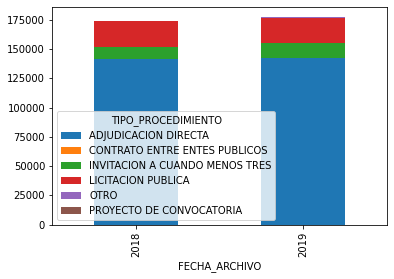

In [79]:
df_procedimientos.groupby(['FECHA_ARCHIVO', 'TIPO_PROCEDIMIENTO']).count().iloc[:, 0].unstack().plot(kind='bar', stacked=True)

**Estratificación de empresa contratante según la UC**

Como a partir de 2018 la ESTRATIFICACION_MUC no se incluye en la base pública de procedimientos tendremos que usar el campo 'exclusivo_mipymes' de la tabla scraper. Ver `procs_con_incumplimiento_de_exclusividad_mipyme` en anomalias.py.

In [80]:
df_procedimientos.ESTRATIFICACION_MPC.value_counts()

MICRO        88708
PEQUENA      68702
NO MIPYME    49278
MEDIANA      43081
Name: ESTRATIFICACION_MPC, dtype: int64

También tenemos que asegurarnos de que la estratificación no tenga valores nulos.

In [81]:
df_procedimientos['ESTRATIFICACION_MUC'] = df_procedimientos['ESTRATIFICACION_MUC'].fillna('NO REPORTADA')
df_procedimientos['ESTRATIFICACION_MPC'] = df_procedimientos['ESTRATIFICACION_MPC'].fillna('NO REPORTADA')

diff = df_procedimientos[df_procedimientos['ESTRATIFICACION_MUC'] != df_procedimientos['ESTRATIFICACION_MPC']]
assert(diff.size == 0)

## 2.2 Scraper

In [286]:
scraper = pd.read_parquet(f'{db_path}/scraper-v2018.parquet', engine='pyarrow')
scraper.head()

,CODIGO_EXPEDIENTE,descripcion,referencia,tipo,categorias,descripcion_anuncio,notas,tipo_contratacion,entidad,fecha_publicacion,...,NUMERO_PROCEDIMIENTO,exclusivo_mipymes,testigo_social,archivo_fallo,archivo_apertura,archivo_junta,archivo_convocatoria,archivo_contrato,numero_archivos,numero_convenios
0,1522226,SERVICIO DE VIGILANCIA,CNF-CGGE-AD-DIR-NAY-2017-009,05. Adjudicación Directa LAASSP,3380-Servicios de vigilancia,SERVICIO DE VIGILANCIA PARA G.E. NAYARIT,Karla María Guzmán Sillas,Servicios,Nayarit,22/10/2017 03:43 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0
0,1604036,"ADQUISICIÓN GRUPOS 010,040, Y CLAVE 2540 URGEN...",ADJ 1222 018 18,05. Adjudicación Directa LAASSP,2530-Medicinas y productos farmacéuticos,"ADQUISICIÓN GRUPOS 010,040, Y CLAVE 2540 URGEN...",JORGE LUIS PANTOJA PADILLA,Adquisiciones,Guanajuato,02/02/2018 05:53 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0
0,1627574,ADQUISICIÓN DE MATERIAL DE OSTEOSINTESIS,AA-019GYR091-E57-2018 / ADJ-DA-42-18,05. Adjudicación Directa LAASSP,"2540-Materiales, accesorios y suministros médicos",ADQUISICIÓN DE MATERIAL DE OSTEOSINTESIS,Jose Leobardo Flores Rodriguez,Adquisiciones,Puebla,01/03/2018 01:56 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0
0,1648823,ACEITE VEGETAL COMESTIBLE,143/33656,05. Adjudicación Directa LAASSP,2380-Mercancías adquiridas para su comercializ...,ACEITE VEGETAL COMESTIBLE,Abismael Reyes Lopez,Adquisiciones,Baja California Sur,27/03/2018 01:01 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0
0,1668556,Vocal de Ópera Ambulante,AD41-092-18,05. Adjudicación Directa LAASSP,"3390-Servicios profesionales, científicos y té...",Vocal de Ópera Ambulante,Brenda Nuñez Plancarte,Servicios,Baja California,04/05/2018 02:48 PM,...,AA-016RHQ001-E841-2017,0.0,0,0,0,0,0,0,0.0,0.0


In [287]:
# Valida que las 2 bases usen el mismo CODIGO_EXPEDIENTE
proc = df_procedimientos.iloc[0]
scra = scraper[scraper['CODIGO_EXPEDIENTE'] == proc.CODIGO_EXPEDIENTE].iloc[0]
assert proc.SIGLAS == 'CENAGAS'
assert proc.SIGLAS == str.split(scra.referencia, '/')[0]

Agrega metadata de contratos a la base del scraper.

In [288]:
cols_scraper = [
    'CODIGO_EXPEDIENTE',
    'archivo_apertura',
    'archivo_contrato',
    'archivo_convocatoria',
    'archivo_fallo',
    'archivo_junta',
    'numero_archivos',
    'numero_convenios',
    'testigo_social',
    'exclusivo_mipymes'
]

# Se selecciona un subconjunto ordenado de columnas
df_scraper = scraper.loc[:, cols_scraper]

# Join con procedimientos para obtener los tipos de contratos, # de contratos, fechas de inicio, CLAVEUC, etc...
cols_procs = [
    'CLAVEUC', 'NUMERO_PROCEDIMIENTO', 'CODIGO_EXPEDIENTE', 'TIPO_PROCEDIMIENTO', 'TIPO_CONTRATACION'
]

df_contratos = (df_procedimientos.groupby(cols_procs, as_index=False)
                                 .CODIGO_CONTRATO.count()
                                 .rename(columns={'CODIGO_CONTRATO': 'numero_contratos'}))
print('Procedimientos agrupados con número de contratos', df_contratos.shape)

# Nos traemos varios campos de la tabla de procedimientos que serán útiles para indicadores
# que dependen de la base del scraper.
df_fechas = df_procedimientos[[
    'CODIGO_EXPEDIENTE',
    'FECHA_INICIO',
    'PROVEEDOR_CONTRATISTA'
]]

df_fechas = df_fechas.drop_duplicates(subset=['CODIGO_EXPEDIENTE'])
df_contratos = pd.merge(df_contratos, df_fechas, on='CODIGO_EXPEDIENTE', how='inner')
df_contratos = df_contratos.astype({'CODIGO_EXPEDIENTE': str})

print('Contratos únicos con fecha', df_contratos.shape)
df_scraper = pd.merge(df_scraper, df_contratos, on='CODIGO_EXPEDIENTE', how='inner')
del df_contratos, df_fechas

print('Base scraper actualizada con info de contratos', df_scraper.shape)
df_scraper.head(3)

Procedimientos agrupados con número de contratos (255281, 6)
Contratos únicos con fecha (255281, 8)
Base scraper actualizada con info de contratos (253846, 17)


,CODIGO_EXPEDIENTE,archivo_apertura,archivo_contrato,archivo_convocatoria,archivo_fallo,archivo_junta,numero_archivos,numero_convenios,testigo_social,exclusivo_mipymes,CLAVEUC,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,numero_contratos,FECHA_INICIO,PROVEEDOR_CONTRATISTA
0,1522226,0,0,0,0,0,0.0,0.0,0,0.0,016RHQ001,AA-016RHQ001-E841-2017,ADJUDICACION DIRECTA,SERVICIOS,1,2018-01-01,SEGURIDAD PRIVADA SERVICIOS DINAMICOS Y ESTRAT...
1,1604036,0,0,0,0,0,0.0,0.0,0,0.0,050GYR027,AA-019GYR027-E36-2018,ADJUDICACION DIRECTA,ADQUISICIONES,2,2018-02-02,DARIER
2,1627574,0,0,0,0,0,0.0,0.0,0,0.0,050GYR091,AA-019GYR091-E57-2018,ADJUDICACION DIRECTA,ADQUISICIONES,1,2018-03-05,B BRAUN AESCULAP DE MEXICO


## 2.3 Montos máximos


Los montos máximos de 2012 a 2017 se heredan del [IRC pasado](https://github.com/imco/IRC/#datos-procesados); para estos años 2018 y 2019 se obtienen del [PEF](https://www.transparenciapresupuestaria.gob.mx/work/models/PTP/Presupuesto/DecretosPEF/Decreto_PEF_2018.pdf) y del [DOF](https://www.dof.gob.mx/nota_detalle.php?codigo=5581629&fecha=11/12/2019) respectivamente.

Para este caso solamente tomaremos 2018 y 2019.

In [85]:
df_montos_maximos = pd.read_csv('../data/bases/Montos_maximos.csv',
                                dtype={'Año': int, 'Adjudicación directa': float, 'INV3': float})

df_montos_maximos.loc[:, 'Tipo de contratación'] = (df_montos_maximos['Tipo de contratación'].str.normalize('NFD')
                                                    .str.encode('ascii', 'ignore')
                                                    .str.decode('utf-8')
                                                    .str.upper())

df_montos_maximos = df_montos_maximos[df_montos_maximos['Año'].between(years[0], years[-1])]
df_montos_maximos

,Año,Tipo de contratación,Adjudicación directa,INV3
0,2019,ADQUISICIONES,636840.0,4392920.0
1,2019,SERVICIOS,636840.0,4392920.0
2,2019,ARRENDAMIENTOS,636840.0,4392920.0
3,2019,OBRA PUBLICA,1808440.0,15569520.0
4,2019,SERVICIOS RELACIONADOS CON LA OP,951200.0,11772840.0
5,2018,ADQUISICIONES,583480.0,4024040.0
6,2018,SERVICIOS,583480.0,4024040.0
7,2018,ARRENDAMIENTOS,583480.0,4024040.0
8,2018,OBRA PUBLICA,1656480.0,14262200.0
9,2018,SERVICIOS RELACIONADOS CON LA OP,871160.0,10785680.0


## 2.4 RFC sancionados

Esta base es la versión actualizada (al 26 de Junio de 2020) de [Tabla de proveedores sancionados](https://github.com/imco/irc#datos-procesados). En esta versión extraemos una actualización del sitio oficial [DIRECTORIO DE PROVEEDORES Y CONTRATISTAS SANCIONADOS](https://directoriosancionados.funcionpublica.gob.mx/SanFicTec/jsp/Ficha_Tecnica/SancionadosN.htm).

Para obtener la lista seleccionamos "TODOS" en el menú, abrimos la consola de desarrollo, y con un query XPath logramos obtener la lista de 1,891 RFC sancionados: `$x('//form[@name="detalle"]/table/tbody/tr/td/font/a/strong/text()').map(e => e.textContent)`.

También vamos a extraer el expediente (de la sanción) ya que con éste, podemos determinar el año en el que incurrió. Para esto último el siguiente XPath es ejecutado: `$x('//form[@name="detalle"]/table/tbody/tr/td/font/a/@onclick').map(e => e.textContent.match(/\d+\/\d+/)[0])`. Ambos listados se vuelven un CSV con el comando `paste -d '|' rfcs.txt expedientes.txt > data/bases/RFC_sancionado.csv`.

La lista aumentó de 1,727 a 1,891 registros.

          PROVEEDOR_CONTRATISTA      Expediente  Year
0        3R INNOVACION Y DISENO  006410041/2013  2013
1                        4PRESS  111370002/2019  2019
2         A AND P INTERNATIONAL  185770002/2016  2016
3            A Y M CONSTRUCTORA  000090121/2006  2006
4  A Y V INDUSTRIAL Y COMERCIAL  184000001/2013  2013


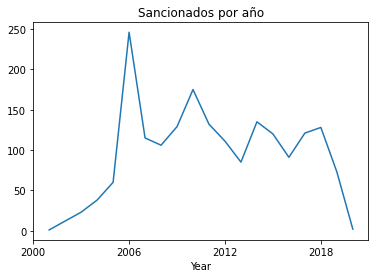

In [86]:
df_sancionados = pd.read_csv('../data/bases/RFC_sancionado.csv',
                             header=None, names=['Proveedor y Contratista ', 'Expediente'], sep='|')

df_sancionados = clean_base_sancionados(df_sancionados)

# El año de la sanción se obtiene del Expediente
get_year = lambda expediente: int(expediente.split('/')[1])
assert get_year('006410041/2013') == 2013

df_sancionados = df_sancionados.assign(Year=df_sancionados.Expediente.map(get_year))

print(df_sancionados.head())
df_sancionados.groupby('Year').agg('count').Expediente.plot(xticks=range(2000, 2020, 6),
                                                            title='Sancionados por año')

## 2.5 RFC fantasma

Esta base es la versión actualizada (al 19 de Febrero de 2020) de [Tabla de RFC fantasma](https://github.com/imco/irc#datos-procesados). En esta versión extraemos el listado de RFCs clasificados como **Definitivos** del sitio oficial [Integración de Sistema del SAT (API) para validación de facturas](http://omawww.sat.gob.mx/cifras_sat/Paginas/datos/vinculo.html?page=ListCompleta69B.html).

In [87]:
df_fantasma = pd.read_csv('../data/bases/Definitivos.csv',
                          dtype={'RFC': str, 'Nombre del Contribuyente': str},
                          encoding='iso-8859-1',
                          parse_dates=['Publicación página SAT definitivos'],
                          skiprows=2,
                          usecols=['RFC', 'Nombre del Contribuyente', 'Publicación página SAT definitivos'])

df_fantasma = df_fantasma.rename(columns={'Nombre del Contribuyente': 'Nombre del Contribuyente'.upper()})

# Filtra los RFC suprimidos
df_fantasma = df_fantasma.loc[df_fantasma.RFC != 'XXXXXXXXXXXX']

df_fantasma = clean_base_rfc(df_fantasma)
df_fantasma

,RFC,PROVEEDOR_CONTRATISTA,Publicación página SAT definitivos
0,AAA120730823,ASESORES Y ADMINISTRADORES AGRICOLAS,25/05/2018
1,AAA121206EV5,AMERICA ADMINISTRATIVA ARROLLO,25/10/2019
2,AAA1502061S0,ACUESY ASESORIA ACUICOLA ESPECIALIZADA DE YUCATAN,16/03/2018
3,AAAA620217U54,AMADOR AQUINO JOSE AVENAMAR,23/11/2018
4,AAAG7012036UA,ARAGON AYALA GRICELDA,25/05/2018
...,...,...,...
9402,ZTM130923IB2,ZADOK TECHNOLOGIES DE MEXICO,25/02/2019
9403,ZTP101230N53,ZARATE TOLEDO Y PACHECO GRUPO CONSULTOR,24/04/2017
9404,ZUCV601108NYA,ZUNIGA CASTILLO VICTOR,23/03/2018
9405,ZUL131022LD6,ZULPER,20/09/2018


## 2.6 Participantes

Esta base es una versión alternativa a la obtenida por Solicitud de Acceso a la Información para el IRC pasado. En esta ocasión utilizamos los registros de la [Plataforma Nacional de Transparencia](#1.3-Plataforma-Nacional-de-Transparencia) para obtener información acerca de competidores que no ganaron los procesos de compra.

In [88]:
df_participantes = pd.read_parquet(f'{db_path}/participantes-v2018.parquet', engine='pyarrow')
df_participantes.shape

(108832, 8)

Antes de insertar FECHA_INICIO

In [89]:
df_participantes[df_participantes['NUMERO_PROCEDIMIENTO'] == 'AA-020VST002-E48-2018']

,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,PROVEEDOR_CONTRATISTA,PRECIO_TOTAL,CLAVEUC,REF_PARTICIPANTES,ESTATUS_DE_PROPUESTA
52,AA-020VST002-E48-2018,ADJUDICACION DIRECTA,ADQUISICIONES,ABEL ZAM,10612.26,020VST002,0,GANADOR
53,AA-020VST002-E48-2018,ADJUDICACION DIRECTA,ADQUISICIONES,COMERCIAL BIOMEDICO JR,31838.52,020VST002,0,GANADOR


In [90]:
duplicados = df_procedimientos.duplicated(subset=['NUMERO_PROCEDIMIENTO'], keep='last')
unicos = df_procedimientos[~duplicados]
print('Números de procedimientos únicos', unicos.shape)
    
# Seleccionamos la última fecha registrada por Número de procedimiento
c = ['NUMERO_PROCEDIMIENTO', 'FECHA_INICIO']
fechas = unicos[c]

# Traemos la FECHA_INICIO a la tabla de participantes
df_participantes = df_participantes.merge(fechas, on='NUMERO_PROCEDIMIENTO')
print('df_participantes con FECHA_INICIO', df_participantes.shape)

# Validamos que los registros mostrados anteriormente ya cuentan con FECHA_INICIO
df_participantes[df_participantes['NUMERO_PROCEDIMIENTO'] == 'AA-020VST002-E48-2018']

Números de procedimientos únicos (256525, 45)
df_participantes con FECHA_INICIO (108832, 9)


,NUMERO_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,TIPO_CONTRATACION,PROVEEDOR_CONTRATISTA,PRECIO_TOTAL,CLAVEUC,REF_PARTICIPANTES,ESTATUS_DE_PROPUESTA,FECHA_INICIO
75,AA-020VST002-E48-2018,ADJUDICACION DIRECTA,ADQUISICIONES,ABEL ZAM,10612.26,020VST002,0,GANADOR,2018-06-15
76,AA-020VST002-E48-2018,ADJUDICACION DIRECTA,ADQUISICIONES,COMERCIAL BIOMEDICO JR,31838.52,020VST002,0,GANADOR,2018-06-15


## 2.7 SIPOT

Obtenida de la [Plataforma Nacional de Transparencia](#1.3-Plataforma-Nacional-de-Transparencia), esta base de datos provee metadatos adicionales al proceso de contratación; pero principalmente la usaremos para compararla contra la base de Compranet.

In [91]:
df_sipot = pd.read_parquet(f'{db_path}/sipot-v2018.parquet', engine='pyarrow')
df_sipot.FECHA_INICIO = pd.to_datetime(df_sipot.FECHA_INICIO)
df_sipot.shape

(382436, 22)

Solo alrededor del 20% de los NUMERO_PROCEDIMIENTO de PNT podrán ser identificados en la base de Compranet, ya que los primeros no cumplen el formato.

In [92]:
n = df_procedimientos.NUMERO_PROCEDIMIENTO.str.match(r'\w+-\w+-\w+-\d+').sum()
print('df_procedimientos', df_procedimientos.shape[0])
print('cumplen el formato de NUMERO_PROCEDIMIENTO', n)

n = df_sipot.NUMERO_PROCEDIMIENTO.str.match(r'\w+-\w+-\w+-\d+').sum()
print('df_sipot', df_sipot.shape[0])
print('cumplen el formato de NUMERO_PROCEDIMIENTO', n, '{:2.2f}%'.format(n / df_sipot.shape[0] * 100))

df_procedimientos 351285
cumplen el formato de NUMERO_PROCEDIMIENTO 351285
df_sipot 382436
cumplen el formato de NUMERO_PROCEDIMIENTO 69857 18.27%


# 3. Cálculo de features

El cálculo de indicadores o features utiliza las bases cargadas en la sección 2. Aquí es donde se calculan variables por cada uno de 4 conceptos (general, falta de competencia, falta de transparencia, anomalías) y por cada uno de los años de nuestro rango.

Las direcciones de salida de los features son '../data/conceptos/{concepto}/{tipo de contratacion}/features.csv'

In [289]:
%autoreload 2


import os

from features.general import (
    conteo_procedimientos,
    monto_total,
    monto_total_por_tipo,
    num_proveedores_unicos,
    numero_contratos,
    numero_contratos_por_tipo
)

from features.competencia import (
    c4_monto_total,
    c4_num_procedimientos,
    contratos_por_proveedor,
    disminucion_en_participacion,
    id_por_contratos,
    id_por_monto,
    ihh_por_contratos,
    ihh_por_monto,
    importe_promedio_por_contrato,
    pc_licitaciones_con_un_participante,
    pc_monto_adj_directa_inv3,
    pc_partipaciones_promedio,
    pc_procedimientos_adj_directa_inv3,
    procs_por_participantes_unicos,
    procs_promedio_por_participantes,
    tendencia_adjudicacion_directa,
    participantes_por_ganadores
)

from features.transparencia import (
    contratos_promedio_por_procedimimento,
    pc_adjudicaciones_incompletas,
    pc_inconsistencias_en_monto,
    pc_invitaciones_incompletas,
    pc_licitaciones_incompletas,
    pc_procs_con_provs_faltantes,
    pc_procs_sin_apertura,
    pc_procs_sin_archivos,
    pc_procs_sin_contrato,
    pc_procs_sin_fallo,
    pc_procs_sin_junta_aclaracion,
    porcentaje_procs_presenciales,
    promedio_datos_faltantes_por_contrato,
    promedio_procs_por_archivo,
    tendencia_no_publicacion_contratos,
    promedio_datos_faltantes_por_contrato_pnt,
    pc_procs_con_testigo_social
)

from features.anomalias import (
    monto_con_rfc_fantasma,
    monto_con_sancionados,
    pc_adj_directas_excedieron_monto,
    pc_contratos_con_convenio,
    pc_estratificacion_mal_reportada,
    pc_invitaciones_excedieron_monto,
    pc_licitaciones_internacionales_menor_20_dias,
    pc_licitaciones_internacionales_menor_40_dias,
    pc_licitaciones_nacionales_menor_15_dias,
    pc_procs_sin_convocatoria,
    promedio_convenios_por_proc,
    procs_con_incumplimiento_de_exclusividad_mipyme,
    pc_adj_directas_excedieron_monto_fraccionado,
    pc_inconsistencias_convenios_pnt_compranet
)

Hacemos un _groupby_ para ver la distribución de registros por Tipo de Contratación y Fecha.

In [174]:
df_procedimientos.groupby(['FECHA_ARCHIVO', 'TIPO_CONTRATACION']).count().iloc[:, 0]

FECHA_ARCHIVO  TIPO_CONTRATACION               
2018           ADQUISICIONES                        92000
               ARRENDAMIENTOS                        1109
               OBRA PUBLICA                          7109
               SERVICIOS                            71106
               SERVICIOS RELACIONADOS CON LA OP      2923
2019           ADQUISICIONES                       101397
               ARRENDAMIENTOS                        1062
               OBRA PUBLICA                          4215
               SERVICIOS                            66565
               SERVICIOS RELACIONADOS CON LA OP      2046
Name: DEPENDENCIA, dtype: int64

Creamos la estructura de directorios para guardar los features CSV a generar.

In [175]:
cwd = '../data/conceptos'
if not os.path.exists(cwd):
    os.mkdir(cwd)
    
for c in conceptos:
    pdir = os.path.join(cwd, c)
    if not os.path.exists(pdir):
        os.mkdir(pdir)
        
    for t in tipos_contratacion:
        subdir = os.path.join(pdir, t)
        if not os.path.exists(subdir):
            os.mkdir(subdir)

El siguiente ciclo pasa por cada año y tipo de contratación y calcula los indicadores seleccionados. Los resultados los escribe en disco en los archivos bajo la carpeta definida anteriormente.

In [290]:
def concatena_concepto(base, indicadores):
    concatenated = pd.concat(indicadores, axis=1, join='outer')
    concatenated.reset_index()
    return base.join(concatenated, how='left', on='CLAVEUC')


for tipo in tipos_contratacion:
    print('*' * 50, '\n' + tipo)
    
    general = pd.DataFrame()
    competencia = pd.DataFrame()
    transparencia = pd.DataFrame()
    anomalias = pd.DataFrame()
    
    # Acumula indicadores por año
    for i, year in enumerate(years):
        print(year)
        
        # sub-tablas por tipo y año
        df_procs_aux = df_procedimientos.loc[            
            (df_procedimientos.TIPO_CONTRATACION == tipo) &
            (df_procedimientos.FECHA_INICIO.dt.year == year)            
        ]
        
        df_scraper_aux = df_scraper.loc[
            (df_scraper.TIPO_CONTRATACION == tipo) &
            (df_scraper.FECHA_INICIO.dt.year == year)
        ]

        df_parts_aux = df_participantes.loc[
            (df_participantes.TIPO_CONTRATACION == tipo) &
            (df_participantes.FECHA_INICIO.dt.year == year)
        ]
        
        df_sipot_aux = df_sipot.loc[
            (df_sipot.TIPO_CONTRATACION == tipo) &
            (df_sipot.FECHA_INICIO.dt.year == year)
        ]
        
        df_base = pd.DataFrame(df_procs_aux.CLAVEUC.unique(), columns=['CLAVEUC'])
        df_base['FECHA'] = year
        
        # - general ---------------------------------
        dfs_general = [
            conteo_procedimientos(df_procs_aux),
            monto_total(df_procs_aux),
            monto_total_por_tipo(df_procs_aux),
            num_proveedores_unicos(df_procs_aux),
            numero_contratos(df_procs_aux),
            numero_contratos_por_tipo(df_procs_aux)
        ]

        dfs_general = [df.set_index('CLAVEUC') for df in dfs_general if df is not None]
        
        print('General', [df.shape[0] for df in dfs_general])
        general = general.append(concatena_concepto(df_base, dfs_general)) 
        print(f'shape general: {general.shape}')
        del dfs_general
        print('-' * 50)

        # - competencia ---------------------
        dfs_competencia = [
            pc_licitaciones_con_un_participante(df_parts_aux),
            procs_promedio_por_participantes(df_parts_aux),
            contratos_por_proveedor(df_procs_aux),
            pc_procedimientos_adj_directa_inv3(df_procs_aux),
            pc_monto_adj_directa_inv3(df_procs_aux),
            ihh_por_contratos(df_procs_aux),
            ihh_por_monto(df_procs_aux),
            id_por_contratos(df_procs_aux),
            id_por_monto(df_procs_aux),
            pc_partipaciones_promedio(df_parts_aux),
            procs_por_participantes_unicos(df_parts_aux),
            c4_num_procedimientos(df_procs_aux),
            c4_monto_total(df_procs_aux),
            importe_promedio_por_contrato(df_procs_aux),
            participantes_por_ganadores(df_parts_aux)
        ]
        
        # Para calcular tendencias se necesita un rango de años.
        if i > 0:
            df_procs_all = df_procedimientos.loc[(df_procedimientos.TIPO_CONTRATACION == tipo)]
            dfs_competencia.append(tendencia_adjudicacion_directa(df_procs_all, year=year))
            dfs_competencia.append(disminucion_en_participacion(df_parts_aux, year=year))
            del df_procs_all

        dfs_competencia = [df.set_index('CLAVEUC') for df in dfs_competencia if df is not None]
        
        print('Competencia', [df.shape[0] for df in dfs_competencia])
        competencia = competencia.append(concatena_concepto(df_base, dfs_competencia))        
        print(f'shape competencia: {competencia.shape}')
        del dfs_competencia
        print('-' * 50)
        
        # - transparencia ----------------------------------
        dfs_transparencia = [
            promedio_datos_faltantes_por_contrato(df_procs_aux),
            pc_adjudicaciones_incompletas(df_scraper_aux),
            pc_invitaciones_incompletas(df_scraper_aux),
            pc_licitaciones_incompletas(df_scraper_aux),
            porcentaje_procs_presenciales(df_procs_aux),
            pc_procs_sin_junta_aclaracion(df_scraper_aux),
            pc_procs_sin_apertura(df_scraper_aux),
            pc_procs_sin_fallo(df_scraper_aux),
            pc_procs_sin_contrato(df_scraper_aux),
            pc_procs_sin_archivos(df_scraper_aux),
            pc_inconsistencias_en_monto(df_procs_aux, df_parts_aux),
            pc_procs_con_provs_faltantes(df_procs_aux, df_parts_aux),
            promedio_datos_faltantes_por_contrato_pnt(df_procs_aux, df_sipot_aux),
            pc_procs_con_testigo_social(df_scraper_aux)
        ]
        
        # Para calcular tendencias se necesita un rango de años.
        if i > 0:
            df_scraper_all = df_scraper.loc[(df_scraper.TIPO_CONTRATACION == tipo)]
            dfs_transparencia.append(tendencia_no_publicacion_contratos(df_scraper_all, year=year))
            del df_scraper_all

        dfs_transparencia = [df.set_index('CLAVEUC') for df in dfs_transparencia if df is not None]

        print('Transparencia', [df.shape[0] for df in dfs_transparencia])
        transparencia = transparencia.append(concatena_concepto(df_base, dfs_transparencia))
        print(f'shape transparencia: {transparencia.shape}')
        del dfs_transparencia
        print('-' * 50)
        
        # - anomalias -
        dfs_anomalias = [
            monto_con_rfc_fantasma(df_procs_aux, df_fantasma),
            monto_con_sancionados(df_procs_aux, df_sancionados),
            pc_contratos_con_convenio(df_procs_aux),
            promedio_convenios_por_proc(df_scraper_aux),
            pc_inconsistencias_convenios_pnt_compranet(df_scraper_aux, df_sipot_aux),
            pc_licitaciones_nacionales_menor_15_dias(df_procs_aux),
            pc_licitaciones_internacionales_menor_20_dias(df_procs_aux),
            pc_licitaciones_internacionales_menor_40_dias(df_procs_aux),
            pc_estratificacion_mal_reportada(df_procs_aux),
            procs_con_incumplimiento_de_exclusividad_mipyme(df_procs_aux, df_scraper_aux),
            pc_adj_directas_excedieron_monto(df_procs_aux, df_montos_maximos, tipo_contratacion=tipo, year=year),
            pc_invitaciones_excedieron_monto(df_procs_aux, df_montos_maximos, tipo_contratacion=tipo, year=year),
            pc_procs_sin_convocatoria(df_scraper_aux),
            pc_adj_directas_excedieron_monto_fraccionado(df_procs_aux, df_montos_maximos, year=year)
        ]
        
        dfs_anomalias = [df.set_index('CLAVEUC') for df in dfs_anomalias if df is not None]

        print('Anomalias', [df.shape[0] for df in dfs_anomalias])  
        anomalias = anomalias.append(concatena_concepto(df_base, dfs_anomalias))
        print(f'shape anomalias: {anomalias.shape}')
        del dfs_anomalias
        print('-' * 50)
        
    # Guarda los indicadores en disco: ../data/conceptos/<conceptos>/{tipo}/features.csv
    general.to_csv(f'../data/conceptos/general/{tipo}/features.csv', index=False, quoting=1, encoding='utf-8')
    del general
    competencia.to_csv(f'../data/conceptos/competencia/{tipo}/features.csv', index=False, quoting=1, encoding='utf-8')
    del competencia
    transparencia.to_csv(f'../data/conceptos/transparencia/{tipo}/features.csv', index=False, quoting=1, encoding='utf-8')
    del transparencia
    anomalias.to_csv(f'../data/conceptos/anomalias/{tipo}/features.csv', index=False, quoting=1, encoding='utf-8')
    del anomalias

************************************************** 
ADQUISICIONES
2018
General [849, 849, 849, 849, 849, 849]
shape general: (849, 12)
--------------------------------------------------
Competencia [208, 208, 849, 849, 849, 849, 849, 849, 849, 207, 208, 849, 849, 849, 208]
shape competencia: (849, 17)
--------------------------------------------------
Transparencia [849, 846, 846, 846, 849, 846, 846, 846, 846, 846, 849, 849, 849, 846]
shape transparencia: (849, 16)
--------------------------------------------------
Anomalias [849, 849, 849, 846, 846, 849, 849, 849, 849, 849, 849, 849, 846, 849]
shape anomalias: (849, 16)
--------------------------------------------------
2019
General [822, 822, 822, 822, 822, 822]
shape general: (1671, 12)
--------------------------------------------------
Competencia [192, 192, 822, 822, 822, 822, 822, 822, 822, 190, 192, 822, 822, 822, 192, 1011, 192]
shape competencia: (1671, 19)
--------------------------------------------------
Transparencia [822,

# 4. Cálculo de IRC

Esta sección muestra como se cálculan los índices de riesgo.

1. Se crea una tabla maestra que contiene todos los indicadores por UC, año, y tipo de contratación.
2. Se normalizan los valores entre 0 y 100.
3. Para aquellos indicadores que cuentan con relación negativa, se hace el ajuste.
4. Se generan las 3 columnas de conceptos, promediando sus respectivos indicadores, p. ej. falta_competencia.
5. Con esto se genera el primer archivo del ir, que es a nivel UC, año, y tipo de contratación.
6. Posteriormente se hace agrupación a UC y a Dependencia.  
6.1 Para la primera, usando la suma ponderada por monto de tipo de contratación,  
6.2 para la segunda la suma ponderada por monto de cada UC.

## 4.1 Unidades Compradoras por Dependencia

Para poder realizar operaciones de agregación a nivel Dependencia por ejemplo, vamos a requerir una manera de asociar la UC a la dependencia. Para esto el campo SIGLAS y DEPENDENCIA nos puede servir como agrupador.

In [291]:
c = ['SIGLAS', 'CLAVEUC', 'NOMBRE_DE_LA_UC']
claves = (df_procedimientos.groupby(c, as_index=False)
          .NUMERO_PROCEDIMIENTO.count())
claves

,SIGLAS,CLAVEUC,NOMBRE_DE_LA_UC,NUMERO_PROCEDIMIENTO
0,AEFCM,011C00999,AEFCM-UNIDAD DE ADMINISTRACION Y FINANZAS DIRE...,312
1,AEM,009JZN996,AEM-AGENCIA ESPACIAL MEXICANA DIRECCION DE ADM...,26
2,AEM,009JZN996,AEM-DIRECCION DE ADMINISTRACION #009JZN996,10
3,AGN,004EZN999,AGN-ARCHIVO GENERAL DE LA NACION #047EZN999,65
4,AGN,047EZN999,AGN-DIRECCION DE ADMINISTRACION #047EZN999,75
...,...,...,...,...
1515,TVMETRO,048MHL001,TVMETRO-DIRECCION DE ADMINISTRACION #048MHL001,518
1516,UNADM,011K00999,UNADM-COORDINACION DE PLANEACION ESTRATEGICA Y...,6
1517,UPN,011A00001,UPN-SECRETARIA ADMINISTRATIVA #011A00001,122
1518,USCMM,011L00999,USCMM-UNIDAD DEL SISTEMA PARA LA CARERA DE LAS...,10


In [292]:
claves.drop('NUMERO_PROCEDIMIENTO', axis=1, inplace=True)
claves.rename(columns={'NOMBRE_DE_LA_UC': 'UC'}, inplace=True)
claves

,SIGLAS,CLAVEUC,UC
0,AEFCM,011C00999,AEFCM-UNIDAD DE ADMINISTRACION Y FINANZAS DIRE...
1,AEM,009JZN996,AEM-AGENCIA ESPACIAL MEXICANA DIRECCION DE ADM...
2,AEM,009JZN996,AEM-DIRECCION DE ADMINISTRACION #009JZN996
3,AGN,004EZN999,AGN-ARCHIVO GENERAL DE LA NACION #047EZN999
4,AGN,047EZN999,AGN-DIRECCION DE ADMINISTRACION #047EZN999
...,...,...,...
1515,TVMETRO,048MHL001,TVMETRO-DIRECCION DE ADMINISTRACION #048MHL001
1516,UNADM,011K00999,UNADM-COORDINACION DE PLANEACION ESTRATEGICA Y...
1517,UPN,011A00001,UPN-SECRETARIA ADMINISTRATIVA #011A00001
1518,USCMM,011L00999,USCMM-UNIDAD DEL SISTEMA PARA LA CARERA DE LAS...


## 4.2 Tabla maestra

Para poder graficar a diferentes niveles de profundidad, pondremos todo en una misma tabla _normalizada_ (ver `escalar_features`). El índice de la tabla será la UC por Tipo de contratración y año.

In [293]:
%autoreload 2

from utils.score_cards import escalar_features, normaliza_columnas, invierte_relacion_de_columnas
from sklearn.preprocessing import MinMaxScaler

In [294]:
%%capture

key_cols = ['CLAVEUC', 'FECHA', 'TIPO_CONTRATACION']

general = []
competencia = []
transparencia = []
anomalias = []

for tipo in tipos_contratacion:
    df = pd.read_csv(f'../data/conceptos/competencia/{tipo}/features.csv')
    df.insert(2, 'TIPO_CONTRATACION', tipo)
    feat_cols = [c for c in df.columns if c not in key_cols]
    competencia.append(df)

    df = pd.read_csv(f'../data/conceptos/transparencia/{tipo}/features.csv')
    df.insert(2, 'TIPO_CONTRATACION', tipo)
    feat_cols = [c for c in df.columns if c not in key_cols]
    transparencia.append(df)
    
    df = pd.read_csv(f'../data/conceptos/anomalias/{tipo}/features.csv')
    df.insert(2, 'TIPO_CONTRATACION', tipo)
    feat_cols = [c for c in df.columns if c not in key_cols]
    anomalias.append(df)
    
    df = pd.read_csv(f'../data/conceptos/general/{tipo}/features.csv')
    df.insert(2, 'TIPO_CONTRATACION', tipo)
    general.append(df)

df_competencia = pd.concat(competencia)
df_transparencia = pd.concat(transparencia)
df_anomalias = pd.concat(anomalias)
df_general = pd.concat(general)

# Agrega columnas de indicadores a la tabla principal
# Empieza con todas las UC y sus dependencias
df_irc = claves.merge(df_competencia, on='CLAVEUC', how='left')
df_irc = df_irc.merge(df_transparencia, on=key_cols, how='left')
df_irc = df_irc.merge(df_anomalias, on=key_cols, how='left')
df_irc = df_irc.merge(df_general, on=key_cols, how='left')

In [295]:
df_irc.shape

(5880, 61)

In [296]:
ej = df_irc[df_irc.CLAVEUC == '021W3S002']
ej

,SIGLAS,CLAVEUC,UC,FECHA,TIPO_CONTRATACION,pc_licitaciones_con_un_participante,procs_promedio_por_participantes,contratos_por_proveedor,pc_procedimientos_adj_directa_inv3,pc_monto_adj_directa_inv3,...,conteo_procedimientos,monto_total,monto_AD,monto_INV3,monto_LP,num_proveedores_unicos,numero_contratos,numero_contratos_AD,numero_contratos_INV3,numero_contratos_LP
2403,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,2018.0,ADQUISICIONES,0.0,0.125000,2.995434,99.843750,93.229528,...,640.0,2.590533e+08,2.415142e+08,0.00,1.753913e+07,219.0,656.0,640.0,0.0,16.0
2404,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,2019.0,ADQUISICIONES,0.0,0.125000,2.666667,99.440299,89.187984,...,536.0,2.157848e+08,1.924542e+08,0.00,2.333069e+07,207.0,552.0,535.0,0.0,17.0
2405,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,2018.0,SERVICIOS,0.0,0.500000,2.631579,98.580122,69.785050,...,493.0,1.611841e+08,9.516321e+07,17319193.24,4.870169e+07,190.0,500.0,483.0,3.0,14.0
2406,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,2019.0,SERVICIOS,0.0,0.266667,2.141304,98.966408,66.197834,...,387.0,1.410216e+08,7.211695e+07,21236266.71,4.766834e+07,184.0,394.0,380.0,3.0,11.0
2407,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,2018.0,ARRENDAMIENTOS,NaN,NaN,1.333333,100.000000,100.000000,...,16.0,5.101214e+06,5.101214e+06,0.00,0.000000e+00,12.0,16.0,16.0,0.0,0.0
2408,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,2019.0,ARRENDAMIENTOS,NaN,NaN,1.823529,100.000000,100.000000,...,31.0,1.126972e+07,1.126972e+07,0.00,0.000000e+00,17.0,31.0,31.0,0.0,0.0
2409,FONATUR MANTENIMIENTO,021W3S002,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,2018.0,ADQUISICIONES,0.0,0.125000,2.995434,99.843750,93.229528,...,640.0,2.590533e+08,2.415142e+08,0.00,1.753913e+07,219.0,656.0,640.0,0.0,16.0
2410,FONATUR MANTENIMIENTO,021W3S002,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,2019.0,ADQUISICIONES,0.0,0.125000,2.666667,99.440299,89.187984,...,536.0,2.157848e+08,1.924542e+08,0.00,2.333069e+07,207.0,552.0,535.0,0.0,17.0
2411,FONATUR MANTENIMIENTO,021W3S002,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,2018.0,SERVICIOS,0.0,0.500000,2.631579,98.580122,69.785050,...,493.0,1.611841e+08,9.516321e+07,17319193.24,4.870169e+07,190.0,500.0,483.0,3.0,14.0
2412,FONATUR MANTENIMIENTO,021W3S002,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,2019.0,SERVICIOS,0.0,0.266667,2.141304,98.966408,66.197834,...,387.0,1.410216e+08,7.211695e+07,21236266.71,4.766834e+07,184.0,394.0,380.0,3.0,11.0


**promedio_datos_faltantes_por_contrato** antes de normalizar

In [297]:
ej.promedio_datos_faltantes_por_contrato

2403    1.951220
2404    1.891304
2405    1.954000
2406    1.916244
2407    2.000000
2408    2.000000
2409    1.951220
2410    1.891304
2411    1.954000
2412    1.916244
2413    2.000000
2414    2.000000
Name: promedio_datos_faltantes_por_contrato, dtype: float64

Guardamos la lista de indicadores para hacer cálculos de conceptos más adelante.

In [298]:
no_key_cols = lambda cols: [c for c in cols if c not in key_cols]
indicadores = {
    'falta_competencia': no_key_cols(df_competencia.columns),
    'falta_transparencia': no_key_cols(df_transparencia.columns),
    'anomalias': no_key_cols(df_anomalias.columns)
}

### 4.2.1 Normalización de columnas

Algunos campos tienen infinitos, derivados de divisiones entre cero.

In [299]:
df_irc.procs_por_participantes_unicos.describe()

count    1305.000000
mean             inf
std              NaN
min         0.008511
25%         0.218750
50%         0.428571
75%         0.688889
max              inf
Name: procs_por_participantes_unicos, dtype: float64

In [300]:
%%capture
# Normaliza features, ignorando np.nan, None, y +/- np.inf
for concepto, columnas in indicadores.items():
    df_irc = escalar_features(df_irc, columnas, (0, 100))

El método de escalar_features ignora tanto `np.nan` y `None`, como `np.inf`

In [301]:
df_irc.procs_por_participantes_unicos.describe()

count    1294.000000
mean        8.320774
std         7.920539
min         0.000000
25%         3.300441
50%         6.641463
75%        10.520491
max       100.000000
Name: procs_por_participantes_unicos, dtype: float64

**Verificamos** que columnas de cada concepto han sido normalizadas.

In [302]:
# competencia
assert df_irc['importe_promedio_por_contrato'].max() <= 100
# transparencia
assert df_irc['pc_inconsistencias_convenios_pnt_compranet'].max() <= 100
# anomalias
assert df_irc['pc_procs_sin_convocatoria'].max() <= 100

**promedio_datos_faltantes_por_contrato** después de normalizar

In [303]:
df_irc[df_irc.CLAVEUC == '021W3S002'].promedio_datos_faltantes_por_contrato

2403    39.024390
2404    37.826087
2405    39.080000
2406    38.324873
2407    40.000000
2408    40.000000
2409    39.024390
2410    37.826087
2411    39.080000
2412    38.324873
2413    40.000000
2414    40.000000
Name: promedio_datos_faltantes_por_contrato, dtype: float64

### 4.2.2 Relación negativa

Después de normalizar los valores quedan entre 0 y 100.
Sin embargo hay que **invertir los valores de ciertos indicadores** para que reflejen la relación con nuestro modelo, p. ej. un alto porcentaje de licitaciones con un participante debería tener un valor cercano a cero porque es una situación penalizable.

In [304]:
negativos = [
    'pc_licitaciones_con_un_participante',
    'pc_procedimientos_adj_directa_inv3',
    'pc_monto_adj_directa_inv3',
    'ihh_por_contratos',
    'ihh_por_monto',
    'id_por_contratos',
    'id_por_monto',
    'tendencia_adjudicacion_directa',
    'pc_partipaciones_promedio',
    'c4_num_procedimientos',
    'c4_monto_total',
    'importe_promedio_por_contrato',
    'participantes_por_ganadores',
    'promedio_datos_faltantes_por_contrato',
    'tendencia_no_publicacion_contratos',
    'pc_adjudicaciones_incompletas',
    'pc_invitaciones_incompletas',
    'pc_licitaciones_incompletas',
    'porcentaje_procs_presenciales',
    'pc_procs_sin_junta_aclaracion',
    'pc_procs_sin_apertura',
    'pc_procs_sin_fallo',
    'pc_procs_sin_contrato',
    'pc_procs_sin_archivos',
    'promedio_datos_faltantes_por_contrato_pnt',
    'pc_procs_con_testigo_social',
    'monto_con_rfc_fantasma',
    'pc_contratos_con_convenio',
    'promedio_convenios_por_proc',
    'pc_inconsistencias_convenios_pnt_compranet',
    'pc_licitaciones_nacionales_menor_15_dias',
    'pc_licitaciones_internacionales_menor_20_dias',
    'pc_licitaciones_internacionales_menor_40_dias',
    'pc_estratificacion_mal_reportada',
    'procs_con_incumplimiento_de_exclusividad_mipyme',
    'pc_adj_directas_excedieron_monto',
    'pc_invitaciones_excedieron_monto',
    'pc_procs_sin_convocatoria',
    'pc_adj_directas_excedieron_monto_fraccionado'
]

In [305]:
assert len(negativos) == 39
assert len(set(negativos)) == 39

In [306]:
ej = df_irc[df_irc.CLAVEUC == '021W3S002']
assert ej.pc_licitaciones_con_un_participante.iloc[0] == 0

df_irc = invierte_relacion_de_columnas(df_irc, negativos)

ej = df_irc[df_irc.CLAVEUC == '021W3S002']
assert ej.pc_licitaciones_con_un_participante.iloc[0] == 100

## 4.3 Cálculo de IRC

In [307]:
irc_cols = list(indicadores.keys())

### 4.3.1 Calificaciones por conceptos
Una vez que cada indicador [de concepto] se transforma a una escala con rango entre 0 y 100 para que exista homogeneidad entre éstos, ahora sacamos un promedio de los indicadores por concepto.

Esto para obtener calificaciones para los conceptos de:
- Falta de Competencia
- Falta de Transparencia
- Anomalías

Es muy importante no utilizar valores infinitos en el cálculo de promedio porque podemos terminar con una columna en ceros.

Algunos campos con infinitos:

In [308]:
df_irc[indicadores['falta_competencia']].describe().iloc[:, :3]

,pc_licitaciones_con_un_participante,procs_promedio_por_participantes,contratos_por_proveedor
count,1305.000000,1294.000000,5879.000000
mean,78.397967,10.817452,0.504344
std,33.763596,9.578535,1.949756
min,0.000000,0.000000,0.000000
25%,66.666667,4.214838,0.000000
50%,100.000000,8.583907,0.153003
75%,100.000000,13.452219,0.516384
max,100.000000,100.000000,100.000000


Reemplazamos los `inf` por `nan` temporalmente para el cálculo:

In [309]:
for concepto, columnas in indicadores.items():
    df_irc[concepto] = (df_irc[columnas]
                        .replace([np.inf, -np.inf], np.nan)
                        .mean(axis=1))

In [310]:
df_irc[indicadores.keys()].head()

,falta_competencia,falta_transparencia,anomalias
0,48.645258,57.050139,62.566100
1,52.209214,64.667379,73.164530
2,54.170784,60.442319,67.389793
3,49.541968,61.108786,76.884227
4,33.812908,81.111111,91.666667


In [311]:
df_irc[irc_cols].describe()

,falta_competencia,falta_transparencia,anomalias
count,5879.000000,5879.000000,5879.000000
mean,43.380446,60.586034,83.170769
std,17.795397,11.804664,7.884595
min,9.088323,19.111111,48.032407
25%,30.093495,51.259259,77.513639
50%,46.914686,60.703704,83.333333
75%,57.818661,69.691622,91.025641
max,80.865204,98.677249,91.669605


In [312]:
df_irc = normaliza_columnas(df_irc, irc_cols)
df_irc[irc_cols]

,falta_competencia,falta_transparencia,anomalias
0,55.110970,47.682379,33.305743
1,60.076295,57.255849,57.593347
2,62.809167,51.945726,44.359828
3,56.360272,52.783352,66.117489
4,34.446446,77.922596,99.993266
...,...,...,...
5875,44.163618,60.500066,69.878992
5876,70.886690,45.546735,52.726674
5877,61.780783,46.072105,59.082964
5878,25.556684,42.612049,71.347981


In [313]:
df_irc[irc_cols].describe()

,falta_competencia,falta_transparencia,anomalias
count,5879.000000,5879.000000,5879.000000
mean,47.776001,52.126349,80.523874
std,24.792658,14.836291,18.068519
min,0.000000,0.000000,0.000000
25%,29.264537,40.404309,67.559864
50%,52.699925,52.274239,80.896409
75%,67.891413,63.570399,98.524277
max,100.000000,100.000000,100.000000


### 4.3.2 Riesgo por UC y contratación
Posteriormente, para calcular el riesgo agregado [por UC y tipo de contratación] promediamos las calificaciones normalizadas.

In [314]:
df_irc = df_irc.assign(riesgo=df_irc[irc_cols].mean(axis=1))

In [315]:
df_irc[irc_cols + ['riesgo']]

,falta_competencia,falta_transparencia,anomalias,riesgo
0,55.110970,47.682379,33.305743,45.366364
1,60.076295,57.255849,57.593347,58.308497
2,62.809167,51.945726,44.359828,53.038240
3,56.360272,52.783352,66.117489,58.420371
4,34.446446,77.922596,99.993266,70.787436
...,...,...,...,...
5875,44.163618,60.500066,69.878992,58.180892
5876,70.886690,45.546735,52.726674,56.386700
5877,61.780783,46.072105,59.082964,55.645284
5878,25.556684,42.612049,71.347981,46.505571


### 4.3.3 Scorecard por UC

In [316]:
def score_card_uc(df_irc, CLAVEUC):
    meta_cols = ['SIGLAS', 'CLAVEUC', 'UC', 'TIPO_CONTRATACION', 'FECHA', 'riesgo']
    card_cols = meta_cols + irc_cols + ['monto_total', 'conteo_procedimientos']
    return df_irc[df_irc.CLAVEUC == CLAVEUC][card_cols]

In [317]:
score_card_uc(df_irc, '021W3S002')

,SIGLAS,CLAVEUC,UC,TIPO_CONTRATACION,FECHA,riesgo,falta_competencia,falta_transparencia,anomalias,monto_total,conteo_procedimientos
2403,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,ADQUISICIONES,2018.0,57.203709,70.982323,27.096868,73.531936,2.590533e+08,640.0
2404,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,ADQUISICIONES,2019.0,65.911418,72.881415,42.312284,82.540556,2.157848e+08,536.0
2405,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,SERVICIOS,2018.0,46.742907,72.875358,27.145389,40.207975,1.611841e+08,493.0
2406,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,SERVICIOS,2019.0,57.032439,74.094464,32.404941,64.597911,1.410216e+08,387.0
2407,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,ARRENDAMIENTOS,2018.0,72.207666,56.658235,61.165049,98.799713,5.101214e+06,16.0
2408,FONATUR INFRAESTRUCTURA,021W3S002,FONATUR INFRAESTRUCTURA-GERENCIA CENTRAL SUBGE...,ARRENDAMIENTOS,2019.0,69.482546,46.725191,63.814198,97.908250,1.126972e+07,31.0
2409,FONATUR MANTENIMIENTO,021W3S002,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,ADQUISICIONES,2018.0,57.203709,70.982323,27.096868,73.531936,2.590533e+08,640.0
2410,FONATUR MANTENIMIENTO,021W3S002,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,ADQUISICIONES,2019.0,65.911418,72.881415,42.312284,82.540556,2.157848e+08,536.0
2411,FONATUR MANTENIMIENTO,021W3S002,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,SERVICIOS,2018.0,46.742907,72.875358,27.145389,40.207975,1.611841e+08,493.0
2412,FONATUR MANTENIMIENTO,021W3S002,FONATUR MANTENIMIENTO-GERENCIA CENTRAL SUBDIRE...,SERVICIOS,2019.0,57.032439,74.094464,32.404941,64.597911,1.410216e+08,387.0


### 4.3.4 Riesgo por UC

Para calcular un riesgo global por UC, debemos filtrar por año y ponderar las calificaciones de riesgo por el monto adjudicado.

In [318]:
montos_anuales = (df_irc.groupby(['CLAVEUC', 'FECHA'])
                  .monto_total.sum()
                  .reset_index()
                  .rename(columns={'monto_total': 'monto_anual_uc'}))
montos_anuales[montos_anuales.CLAVEUC == '021W3S002']

,CLAVEUC,FECHA,monto_anual_uc
1842,021W3S002,2018.0,8.506772e+08
1843,021W3S002,2019.0,7.361522e+08


El monto anual nos sirve para determinar el peso de cada TIPO_CONTRATACION en el riesgo de una UC.

In [319]:
df_riesgo_ponderado = df_irc.merge(montos_anuales)
df_riesgo_ponderado['peso'] = df_riesgo_ponderado['monto_total'].divide(df_riesgo_ponderado['monto_anual_uc'])
df_riesgo_ponderado['riesgo_ponderado'] = df_riesgo_ponderado['riesgo'] * df_riesgo_ponderado['peso']

In [320]:
ej = df_riesgo_ponderado[df_riesgo_ponderado.CLAVEUC == '021W3S002']
ej[['TIPO_CONTRATACION', 'FECHA', 'riesgo', 'peso', 'riesgo_ponderado']]

,TIPO_CONTRATACION,FECHA,riesgo,peso,riesgo_ponderado
2402,ADQUISICIONES,2018.0,57.203709,0.304526,17.420014
2403,SERVICIOS,2018.0,46.742907,0.189477,8.856724
2404,ARRENDAMIENTOS,2018.0,72.207666,0.005997,0.433004
2405,ADQUISICIONES,2018.0,57.203709,0.304526,17.420014
2406,SERVICIOS,2018.0,46.742907,0.189477,8.856724
2407,ARRENDAMIENTOS,2018.0,72.207666,0.005997,0.433004
2408,ADQUISICIONES,2019.0,65.911418,0.293125,19.320304
2409,SERVICIOS,2019.0,57.032439,0.191566,10.925462
2410,ARRENDAMIENTOS,2019.0,69.482546,0.015309,1.063705
2411,ADQUISICIONES,2019.0,65.911418,0.293125,19.320304


Una vez que tenemos los riesgos ponderados podemos **sumarlos para encontrar el riesgo global**.

In [321]:
df_riesgo_uc_aux = (df_riesgo_ponderado.groupby(['CLAVEUC', 'FECHA'])
                .riesgo_ponderado.sum()
                .reset_index()
                .rename(columns={'riesgo_ponderado': 'riesgo'}))
df_riesgo_uc_aux.head()

,CLAVEUC,FECHA,riesgo
0,002000997,2018.0,56.803630
1,002000998,2018.0,78.165085
2,002000999,2018.0,55.816355
3,002000999,2019.0,41.680246
4,004000998,2018.0,49.026517


In [322]:
df_riesgo_uc_aux[df_riesgo_uc_aux.CLAVEUC == '021W3S002']

,CLAVEUC,FECHA,riesgo
1842,021W3S002,2018.0,53.419485
1843,021W3S002,2019.0,62.618942


In [323]:
c = ['SIGLAS', 'CLAVEUC', 'UC', 'FECHA', 'riesgo']
df_riesgo_uc = pd.merge(df_riesgo_uc_aux, claves, how='left')[c]
df_riesgo_uc = df_riesgo_uc.merge(montos_anuales, how='left')
df_riesgo_uc.shape

(2688, 6)

In [324]:
df_riesgo_uc[df_riesgo_uc.FECHA == 2019].nlargest(10, 'riesgo')

,SIGLAS,CLAVEUC,UC,FECHA,riesgo,monto_anual_uc
291,ASERCA,008F00003,ASERCA-DIRECCION REGIONAL NOROESTE #008F00003,2019.0,81.202612,6.484802e+06
1808,CONUEE,018E00999,CONUEE-DIRECCION GENERAL ADJUNTA DE ADMINISTRA...,2019.0,79.065337,8.076978e+06
1039,CINVESTAV,011L4J994,CINVESTAV-RECURSOS MATERIALES #011L4J994,2019.0,78.444083,1.004805e+07
297,ASERCA,008F00994,ASERCA-DIRECCION REGIONAL NORESTE #008F00994,2019.0,78.305329,2.817921e+06
2074,ECOSUR,03891E997,ECOSUR-ADMINISTRACION CHETUMAL #03891E997,2019.0,78.127665,5.704552e+06
2072,ECOSUR,03891E996,ECOSUR-DEPARTAMENTO ADMINISTRATIVO DE LA UNIDA...,2019.0,78.122886,7.412450e+06
300,ASERCA,008F00995,ASERCA-DIRECCION REGIONAL ISTMO #008F00995,2019.0,77.986474,3.306916e+06
301,ASERCA,008F00995,ASERCA-REGIONAL ISTMO #008F00995,2019.0,77.986474,3.306916e+06
309,ASERCA,008F00999,ASERCA-DIRECCION REGIONAL OCCIDENTE #008F00999,2019.0,77.821911,2.187000e+06
400,INIFAP,008JAG011,INIFAP-DIRECCION DE ADMINISTRACION DEL CENTRO ...,2019.0,77.698181,2.240925e+06


### 4.3.5 Riesgo por Dependencia

Realizamos un proceso similar al riesgo por UC.

In [325]:
# Agregamos los montos de UC para encontrar el total por dependencia
montos_anuales_dep = (df_riesgo_uc.groupby(['SIGLAS', 'FECHA'])
                      .monto_anual_uc.sum()
                      .reset_index()
                      .rename(columns={'monto_anual_uc': 'monto_anual_dependencia'}))

# Ponderación de riesgo usando los montos anuales de UC vs dependencia
df_rp = df_riesgo_uc.merge(montos_anuales_dep)
df_rp['peso'] = df_rp['monto_anual_uc'].divide(df_rp['monto_anual_dependencia'])
df_rp['riesgo_ponderado'] = df_rp['riesgo'] * df_rp['peso']

# Sumamos el riesgo ponderado de las UC
df_riesgo_dependencia = (df_rp.groupby(['SIGLAS', 'FECHA'])
                         .riesgo_ponderado.sum()
                         .reset_index()
                         .rename(columns={'riesgo_ponderado': 'riesgo'}))

In [326]:
df_riesgo_dependencia.nlargest(10, 'riesgo')

,SIGLAS,FECHA,riesgo
176,CONADESUCA,2018.0,81.213002
219,CONUEE,2019.0,79.065337
11,APBP,2019.0,77.316107
238,EDUCAL,2018.0,77.267492
122,CIMAV,2019.0,77.043500
420,ONCETV,2018.0,75.952683
386,INPER,2018.0,74.996584
121,CIMAV,2018.0,74.895676
239,EDUCAL,2019.0,74.383877
148,CNSNS,2018.0,74.165153


Debemos tener el mismo número de UC en la tabla maestra final de IRC que en los procedimientos de Compranet

In [327]:
assert df_procedimientos.CLAVEUC.nunique() == df_irc.CLAVEUC.nunique()

### 4.3.6 Guardamos en disco

In [328]:
df_irc.to_csv(f'{db_path}/irc-uc-contratacion.csv', sep='|', encoding='utf-8', index=False, quoting=1)
df_riesgo_uc.to_csv(f'{db_path}/irc-uc.csv', sep='|', encoding='utf-8', index=False, quoting=1)
df_riesgo_dependencia.to_csv(f'{db_path}/irc-dependencia.csv', sep='|', encoding='utf-8', index=False, quoting=1)